In [1]:
# !pip install git+https://github.com/cleanlab/cleanlab.git
import os
import pickle
import numpy as np

import torch
import torchvision
import timm
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from cleanlab.outlier import OutOfDistribution
from cleanlab.rank import find_top_issues
from torchvision import datasets, transforms
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.manifold import TSNE
import seaborn as sns

from model import Net, GtsrbFolderWithPaths
from classes_name import classes_name

In [2]:
classes = 42 # 0-42
parent_dir = '../datasets/gtsrb-german-traffic-sign'
    
k = 4
kfold_dir = f'{parent_dir}/{k}fold_noisy1'
data_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
#     transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
])

if torch.cuda.is_available():
    use_gpu = True
    #Instantiating CUDA device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #Verifying CUDA
    print("Using GPU")
    print(device)

else:
	use_gpu = False
	print("Using CPU")


FloatTensor = torch.cuda.FloatTensor if use_gpu else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_gpu else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_gpu else torch.ByteTensor
Tensor = FloatTensor

i_fold = 0
epoch = 1
modelname = f'model{i_fold}_noisy1_{epoch}.pth'
state_dict = torch.load(modelname)

model_traffic = Net()
model_traffic.load_state_dict(state_dict)
model_traffic.eval()
    
for i in range(k):

    if i != i_fold:
        continue

    train_dir = f'{kfold_dir}/{i}/Train'
    test_dir = f'{kfold_dir}/{i}/Test'

    trainset = GtsrbFolderWithPaths(train_dir, classes_name, transform=data_transforms)
    testset = GtsrbFolderWithPaths(test_dir, classes_name, transform=data_transforms)
    print(len(trainset))
    print(len(testset))
    # Load Datasets
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset), shuffle=False, num_workers=4)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False, num_workers=4)

    
    
train_loadar_iterator = iter(train_loader)
_, train_labels_gt, train_paths = next(train_loadar_iterator)
train_labels_gt = train_labels_gt.tolist()
train_labels_gt_des = [classes_name[i] for i in train_labels_gt]
train_imgnames = [os.path.basename(i) for i in train_paths]

test_loadar_iterator = iter(test_loader)
_, test_labels_gt, test_paths = next(test_loadar_iterator)
test_labels_gt = test_labels_gt.tolist()
test_labels_gt_des = [classes_name[i] for i in test_labels_gt]
test_imgnames = [os.path.basename(i) for i in test_paths]

total_labels_gt = train_labels_gt + test_labels_gt
total_labels_gt_des = train_labels_gt_des + test_labels_gt_des
total_imgnames = train_imgnames + test_imgnames

# (_, test_labels_gt, test_paths) = iter(test_loader)
# print(train_labels_gt)
# print(train_labels_gt)

Using GPU
cuda:0
29400
9809


In [3]:
# Generates 2048-dimensional feature embeddings from images
def embed_images(model, dataloader, modelname):
    
    feature_embeddings = []
    
    for data in dataloader:
        
        images, labels, paths = data
        
        with torch.no_grad():
            
            if modelname == 'resnet50':
                embeddings = model(images)
                
            elif modelname == 'traffic':
                embeddings = model_traffic.embedding(images)
                
            feature_embeddings.extend(embeddings.numpy())
            
    feature_embeddings = np.array(feature_embeddings)
    
    return feature_embeddings  # each row corresponds to embedding of a different image

In [4]:
# Note: This pulldown content is for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.

def imshow(img):
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

def plot_images(dataset, show_labels=True):
    plt.rcParams["figure.figsize"] = (9,7)
    plt.figure(dpi=300)
    for i in range(15):
        X,y, path = dataset[i]
        img_name = os.path.basename(path)
        ax = plt.subplot(3,5,i+1)
        
        if show_labels:
            title = f'{img_name}\n{classes_name[int(y)]}'
            ax.set_title(title, fontsize=6)
        ax.imshow(imshow(X))
        ax.axis('off')
    plt.show()
    plt.tight_layout(h_pad=2.0)
    
#     title = f"{imgnames[id]}\ngt({y[id]}): {classes_name[y[id]]}\npred({labels_pred[id]}): {classes_name[int(labels_pred[id])]}\nloss: {losses[id]:.7f}"
#     plt.title(title, fontdict={'fontsize': 4, 'fontweight': 4})

def visualize_outliers(idxs, data):
    data_subset = torch.utils.data.Subset(data, idxs)
    plot_images(data_subset)

In [5]:
# Load pretrained neural network
model = timm.create_model('resnet50', pretrained=True, num_classes=0)  # this is a pytorch network
model.eval()  # eval mode disables training-time operators (like batch normalization)


# Generate feature embeddings
train_feature_embeddings = embed_images(model, train_loader, modelname='resnet50')
print(f'Train embeddings pooled shape: {train_feature_embeddings.shape}')
test_feature_embeddings = embed_images(model, test_loader, modelname='resnet50')
print(f'Test embeddings pooled shape: {test_feature_embeddings.shape}')

train_feature_embeddings_traffic = embed_images(model_traffic, train_loader, modelname='traffic')
print(f'Train embeddings_traffic pooled shape: {train_feature_embeddings_traffic.shape}')
test_feature_embeddings_traffic = embed_images(model_traffic, test_loader, modelname='traffic')
print(f'Test embeddings_traffic pooled shape: {test_feature_embeddings_traffic.shape}')

Train embeddings pooled shape: (29400, 2048)
Test embeddings pooled shape: (9809, 2048)


/home/belay/miniconda3/envs/py38/lib/python3.8/site-packages/torch/nn/functional.py:4277: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/belay/miniconda3/envs/py38/lib/python3.8/site-packages/torch/nn/functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Train embeddings_traffic pooled shape: (29400, 1000)
Test embeddings_traffic pooled shape: (9809, 1000)


----------- resnet50 model -----------
Fitting OOD estimator based on provided features ...


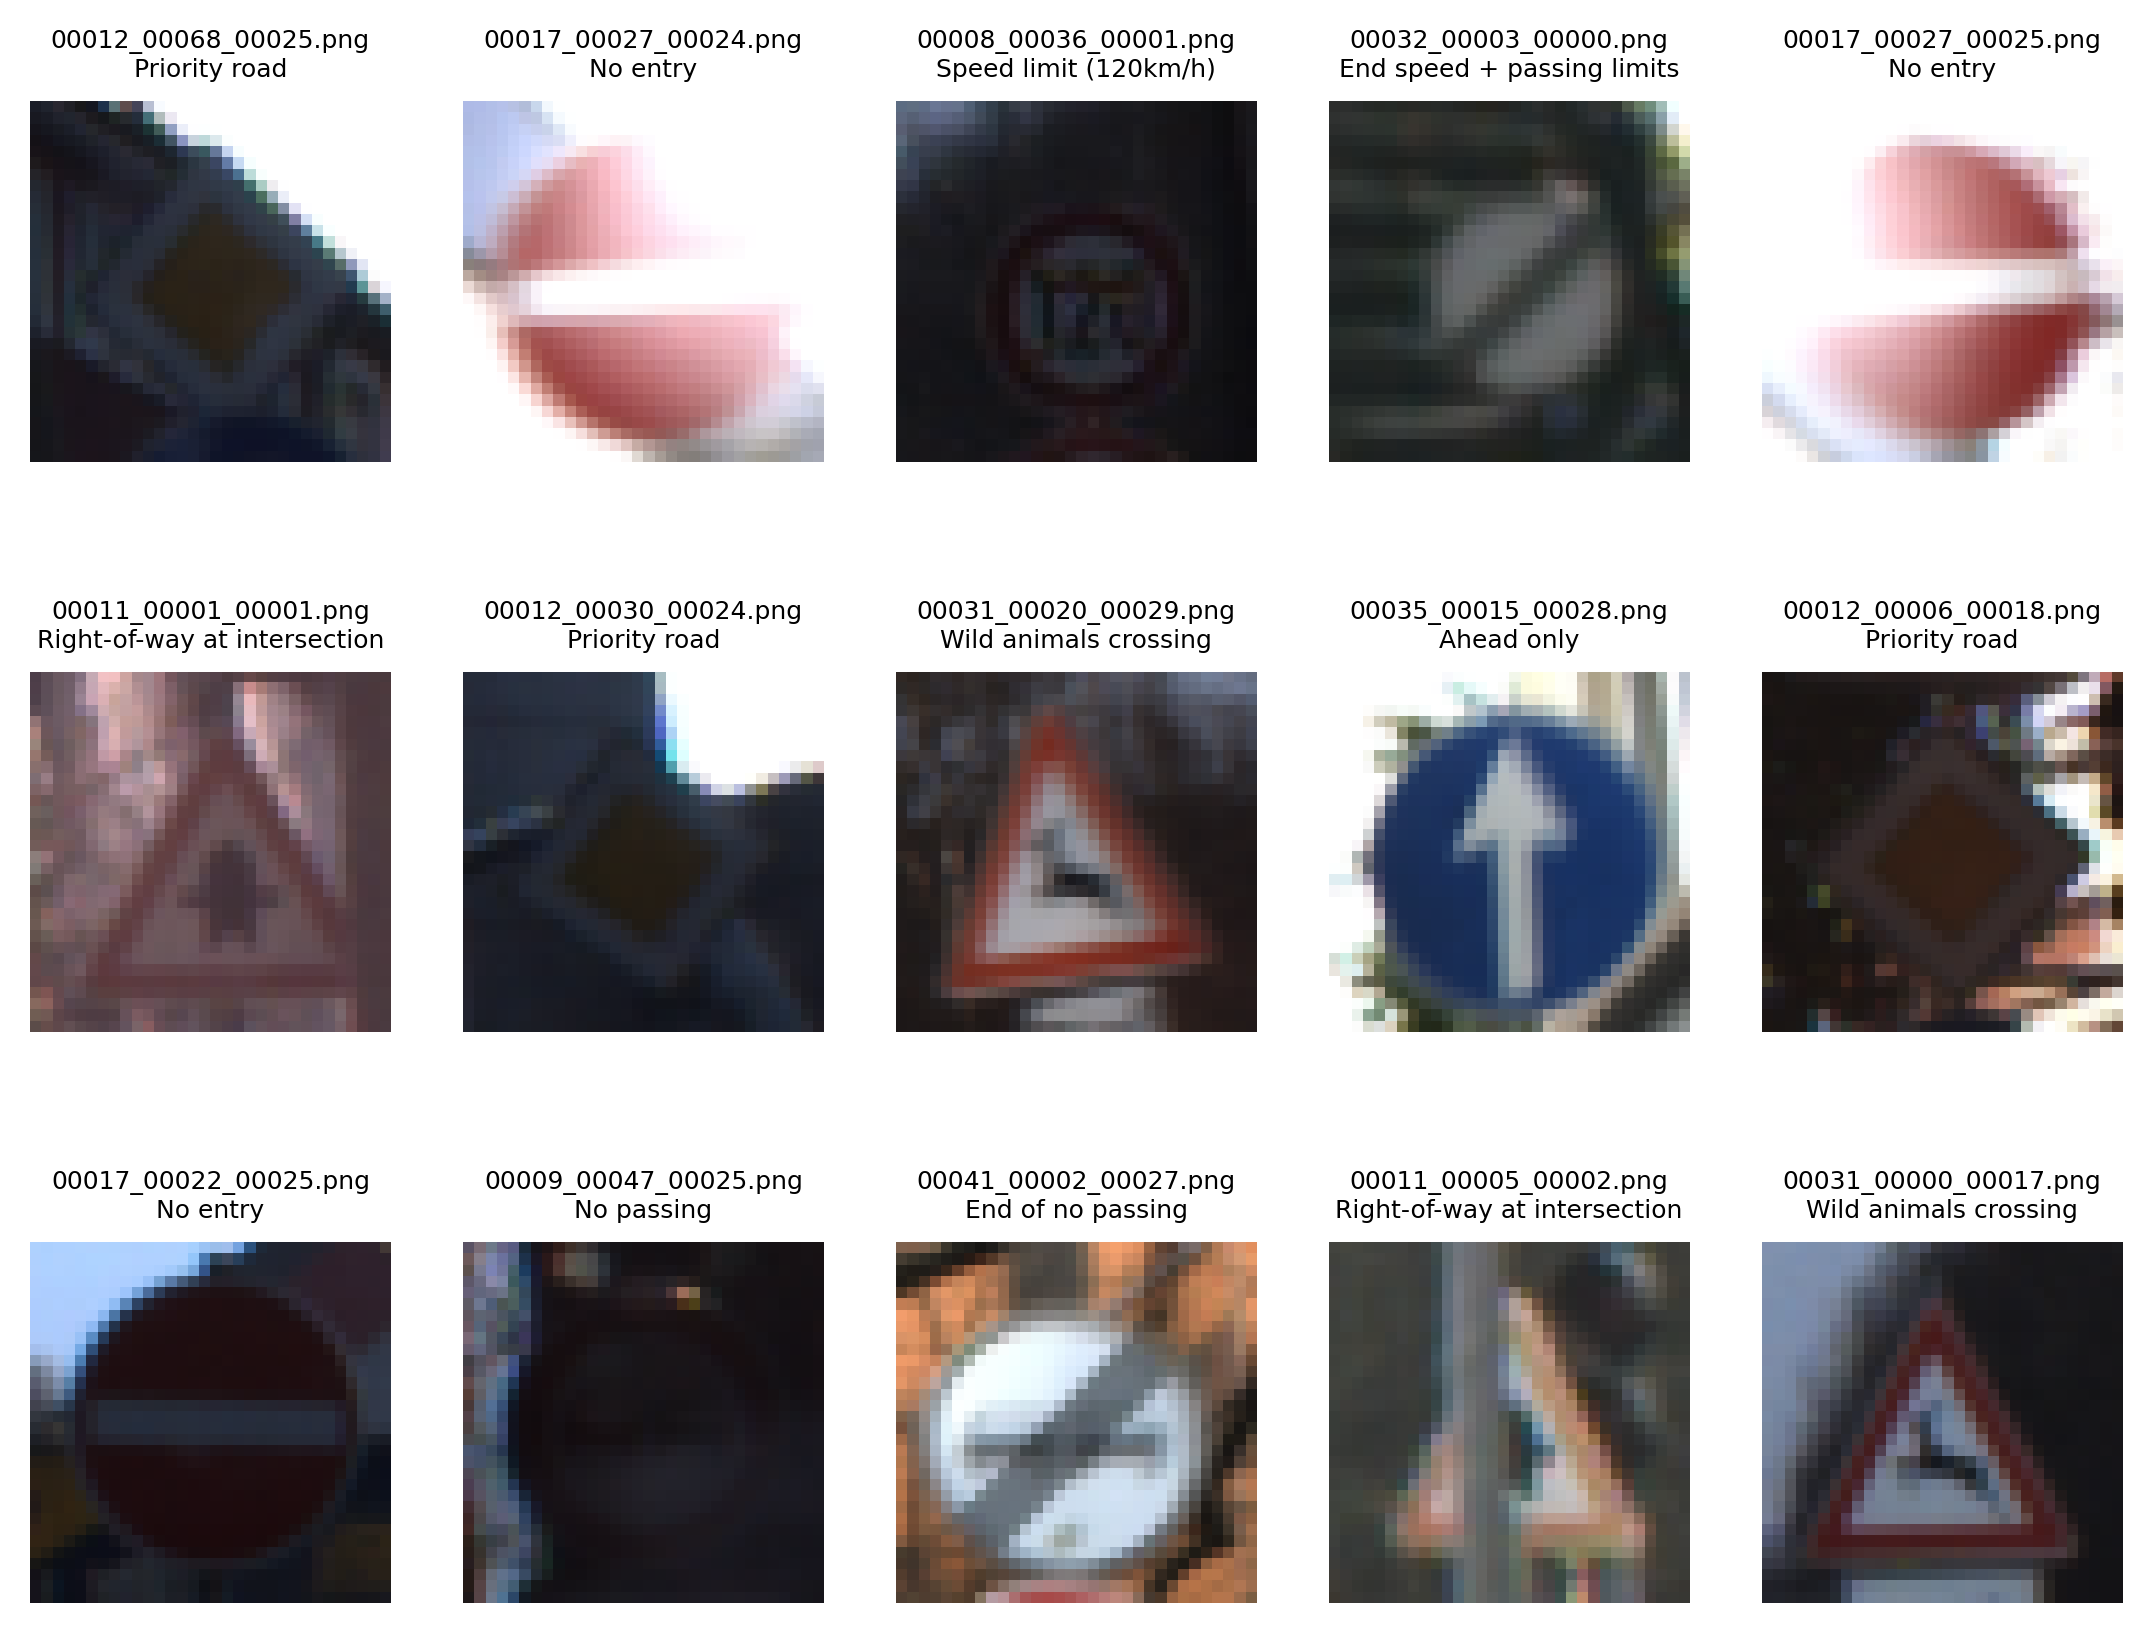

train_ood_features_scores=[0.9463742  0.9507309  0.9375201  ... 0.9926135  0.8240724  0.92422223]
----------- traffic model -----------


/home/belay/miniconda3/envs/py38/lib/python3.8/site-packages/cleanlab-2.2.1-py3.8.egg/cleanlab/outlier.py:329: UserWarning: A KNN estimator has previously already been fit, call score() to apply it to data, or create a new OutOfDistribution object to fit a different estimator.
  warnings.warn(


<Figure size 900x700 with 0 Axes>

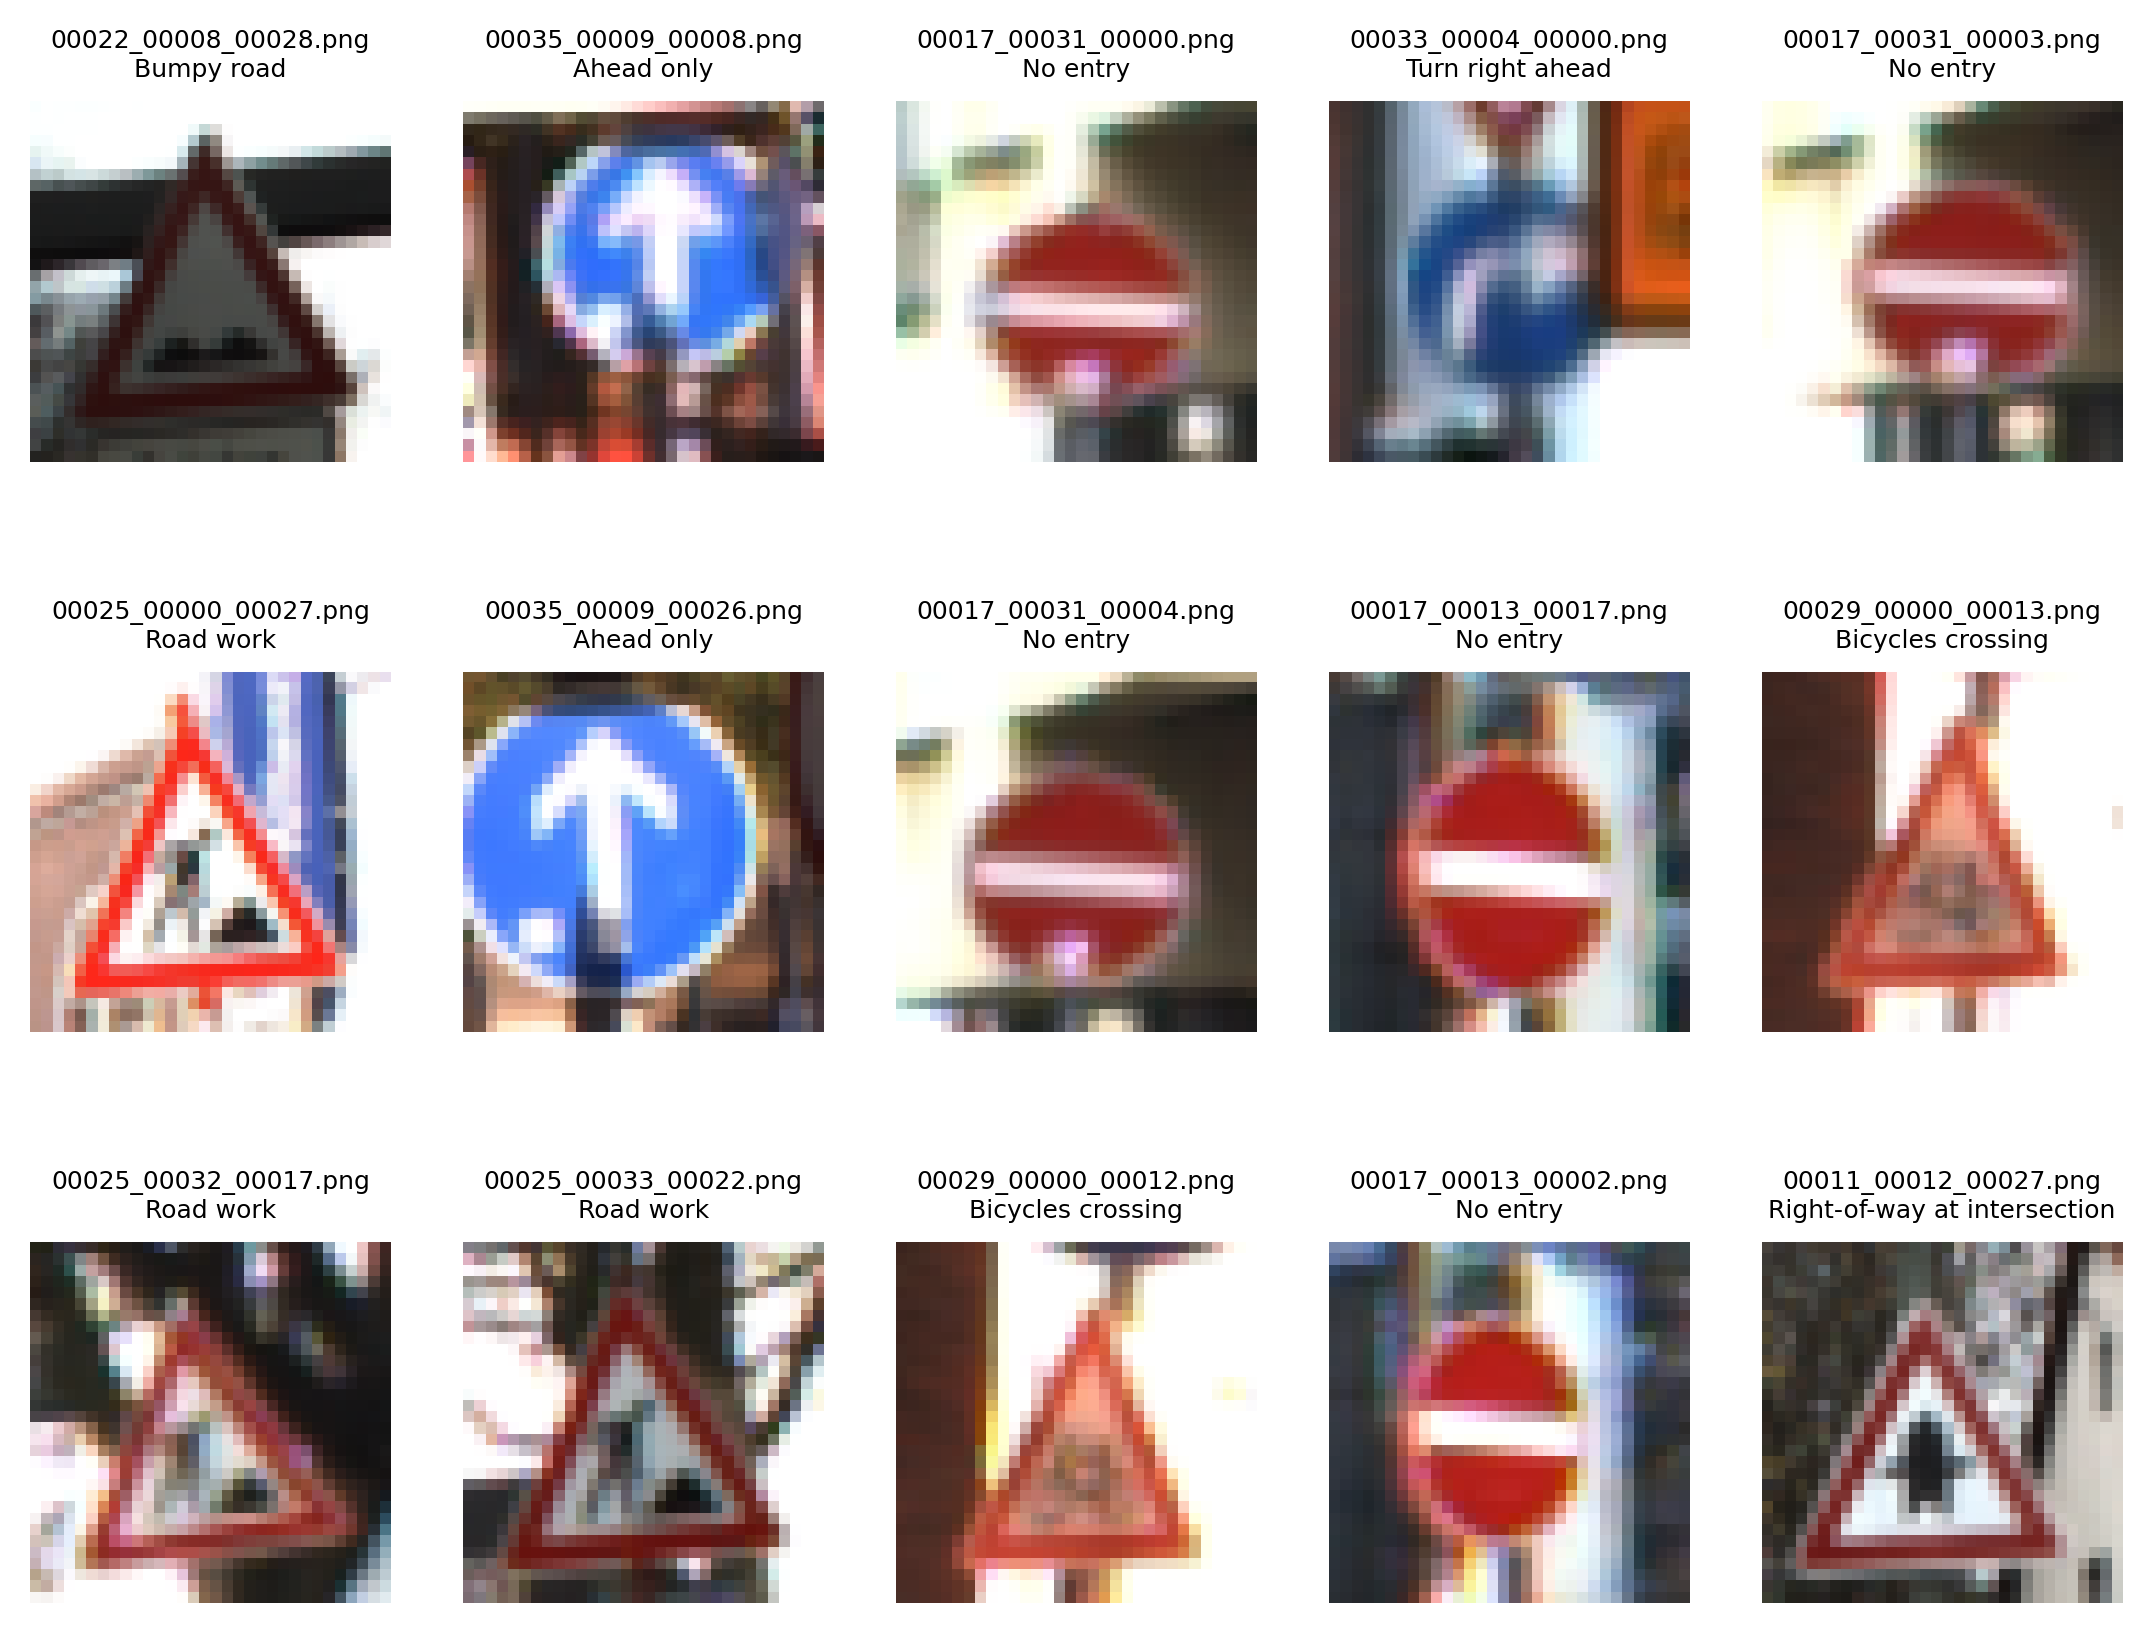

<Figure size 900x700 with 0 Axes>

In [6]:
print('----------- resnet50 model -----------')
ood = OutOfDistribution()
train_ood_features_scores = ood.fit_score(features=train_feature_embeddings)

top_train_ood_features_idxs = find_top_issues(quality_scores=train_ood_features_scores, top=15)
visualize_outliers(top_train_ood_features_idxs, trainset)
print(f'train_ood_features_scores={train_ood_features_scores}')

print('----------- traffic model -----------')
knn = NearestNeighbors(n_neighbors=10, metric="cosine").fit(train_feature_embeddings_traffic)
ood_traffic = OutOfDistribution(params={'knn': knn})
train_ood_features_scores_traffic = ood_traffic.fit_score(features=train_feature_embeddings_traffic)

top_train_ood_features_idxs = find_top_issues(quality_scores=train_ood_features_scores_traffic, top=15)
visualize_outliers(top_train_ood_features_idxs, trainset)

----------- resnet50 model -----------


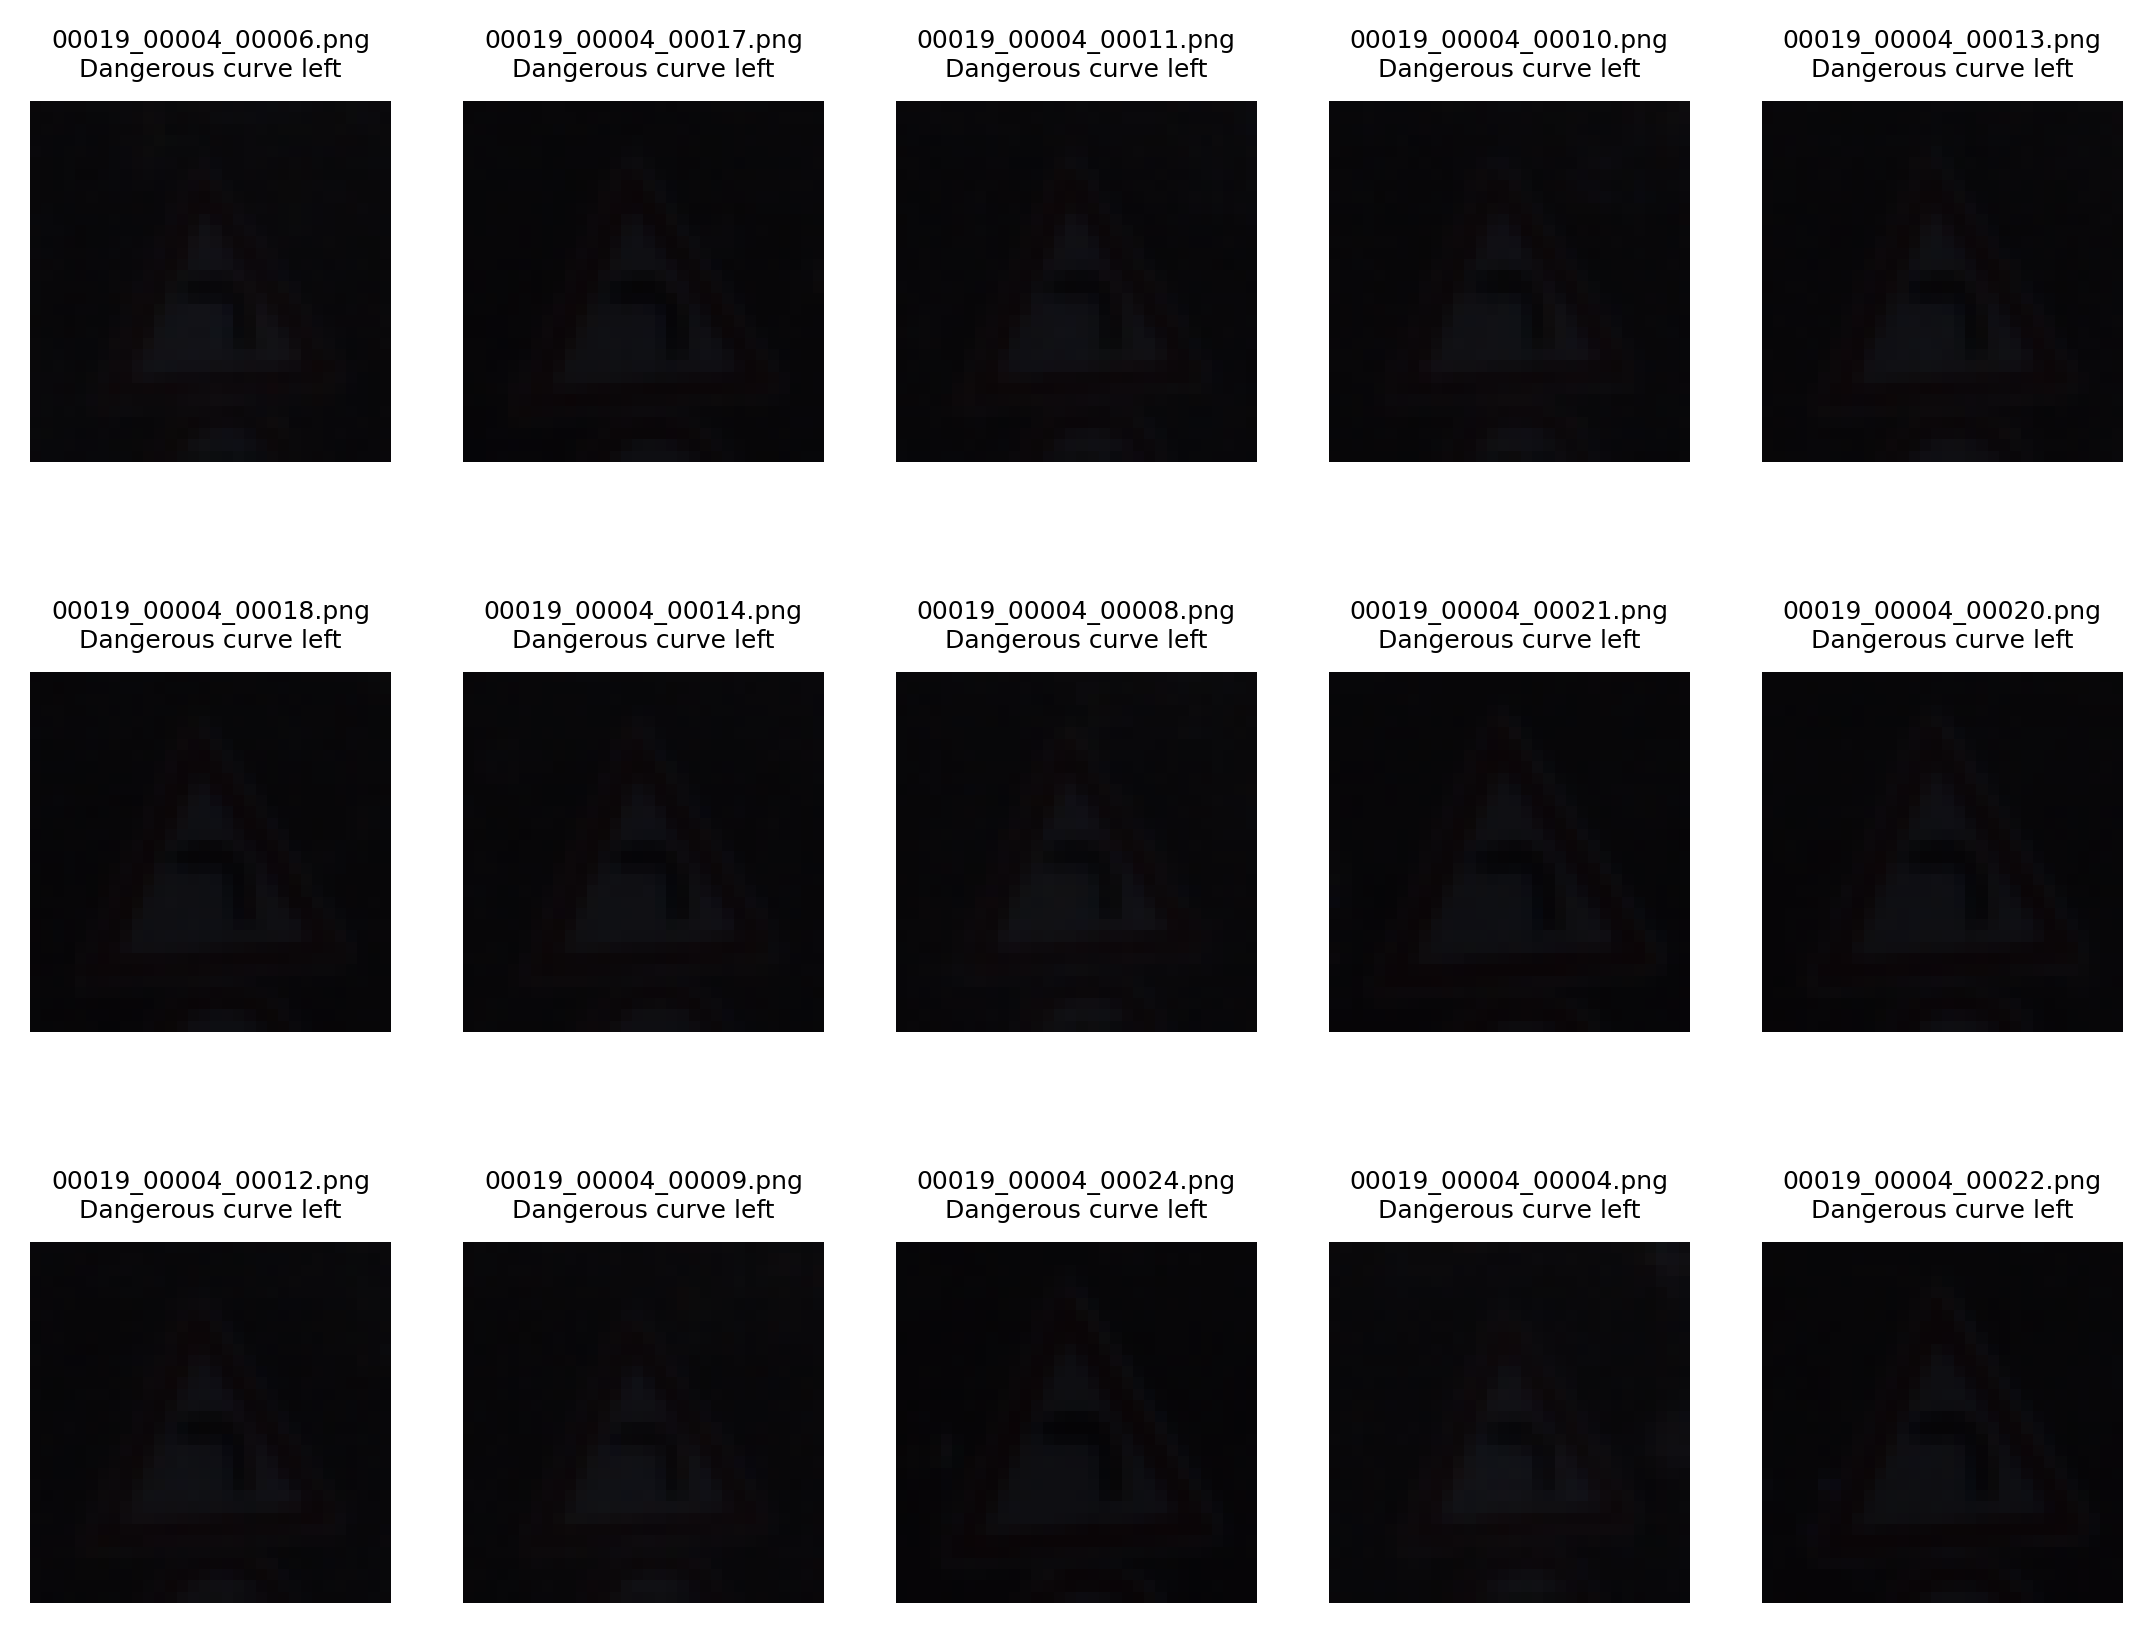

----------- traffic model -----------


<Figure size 900x700 with 0 Axes>

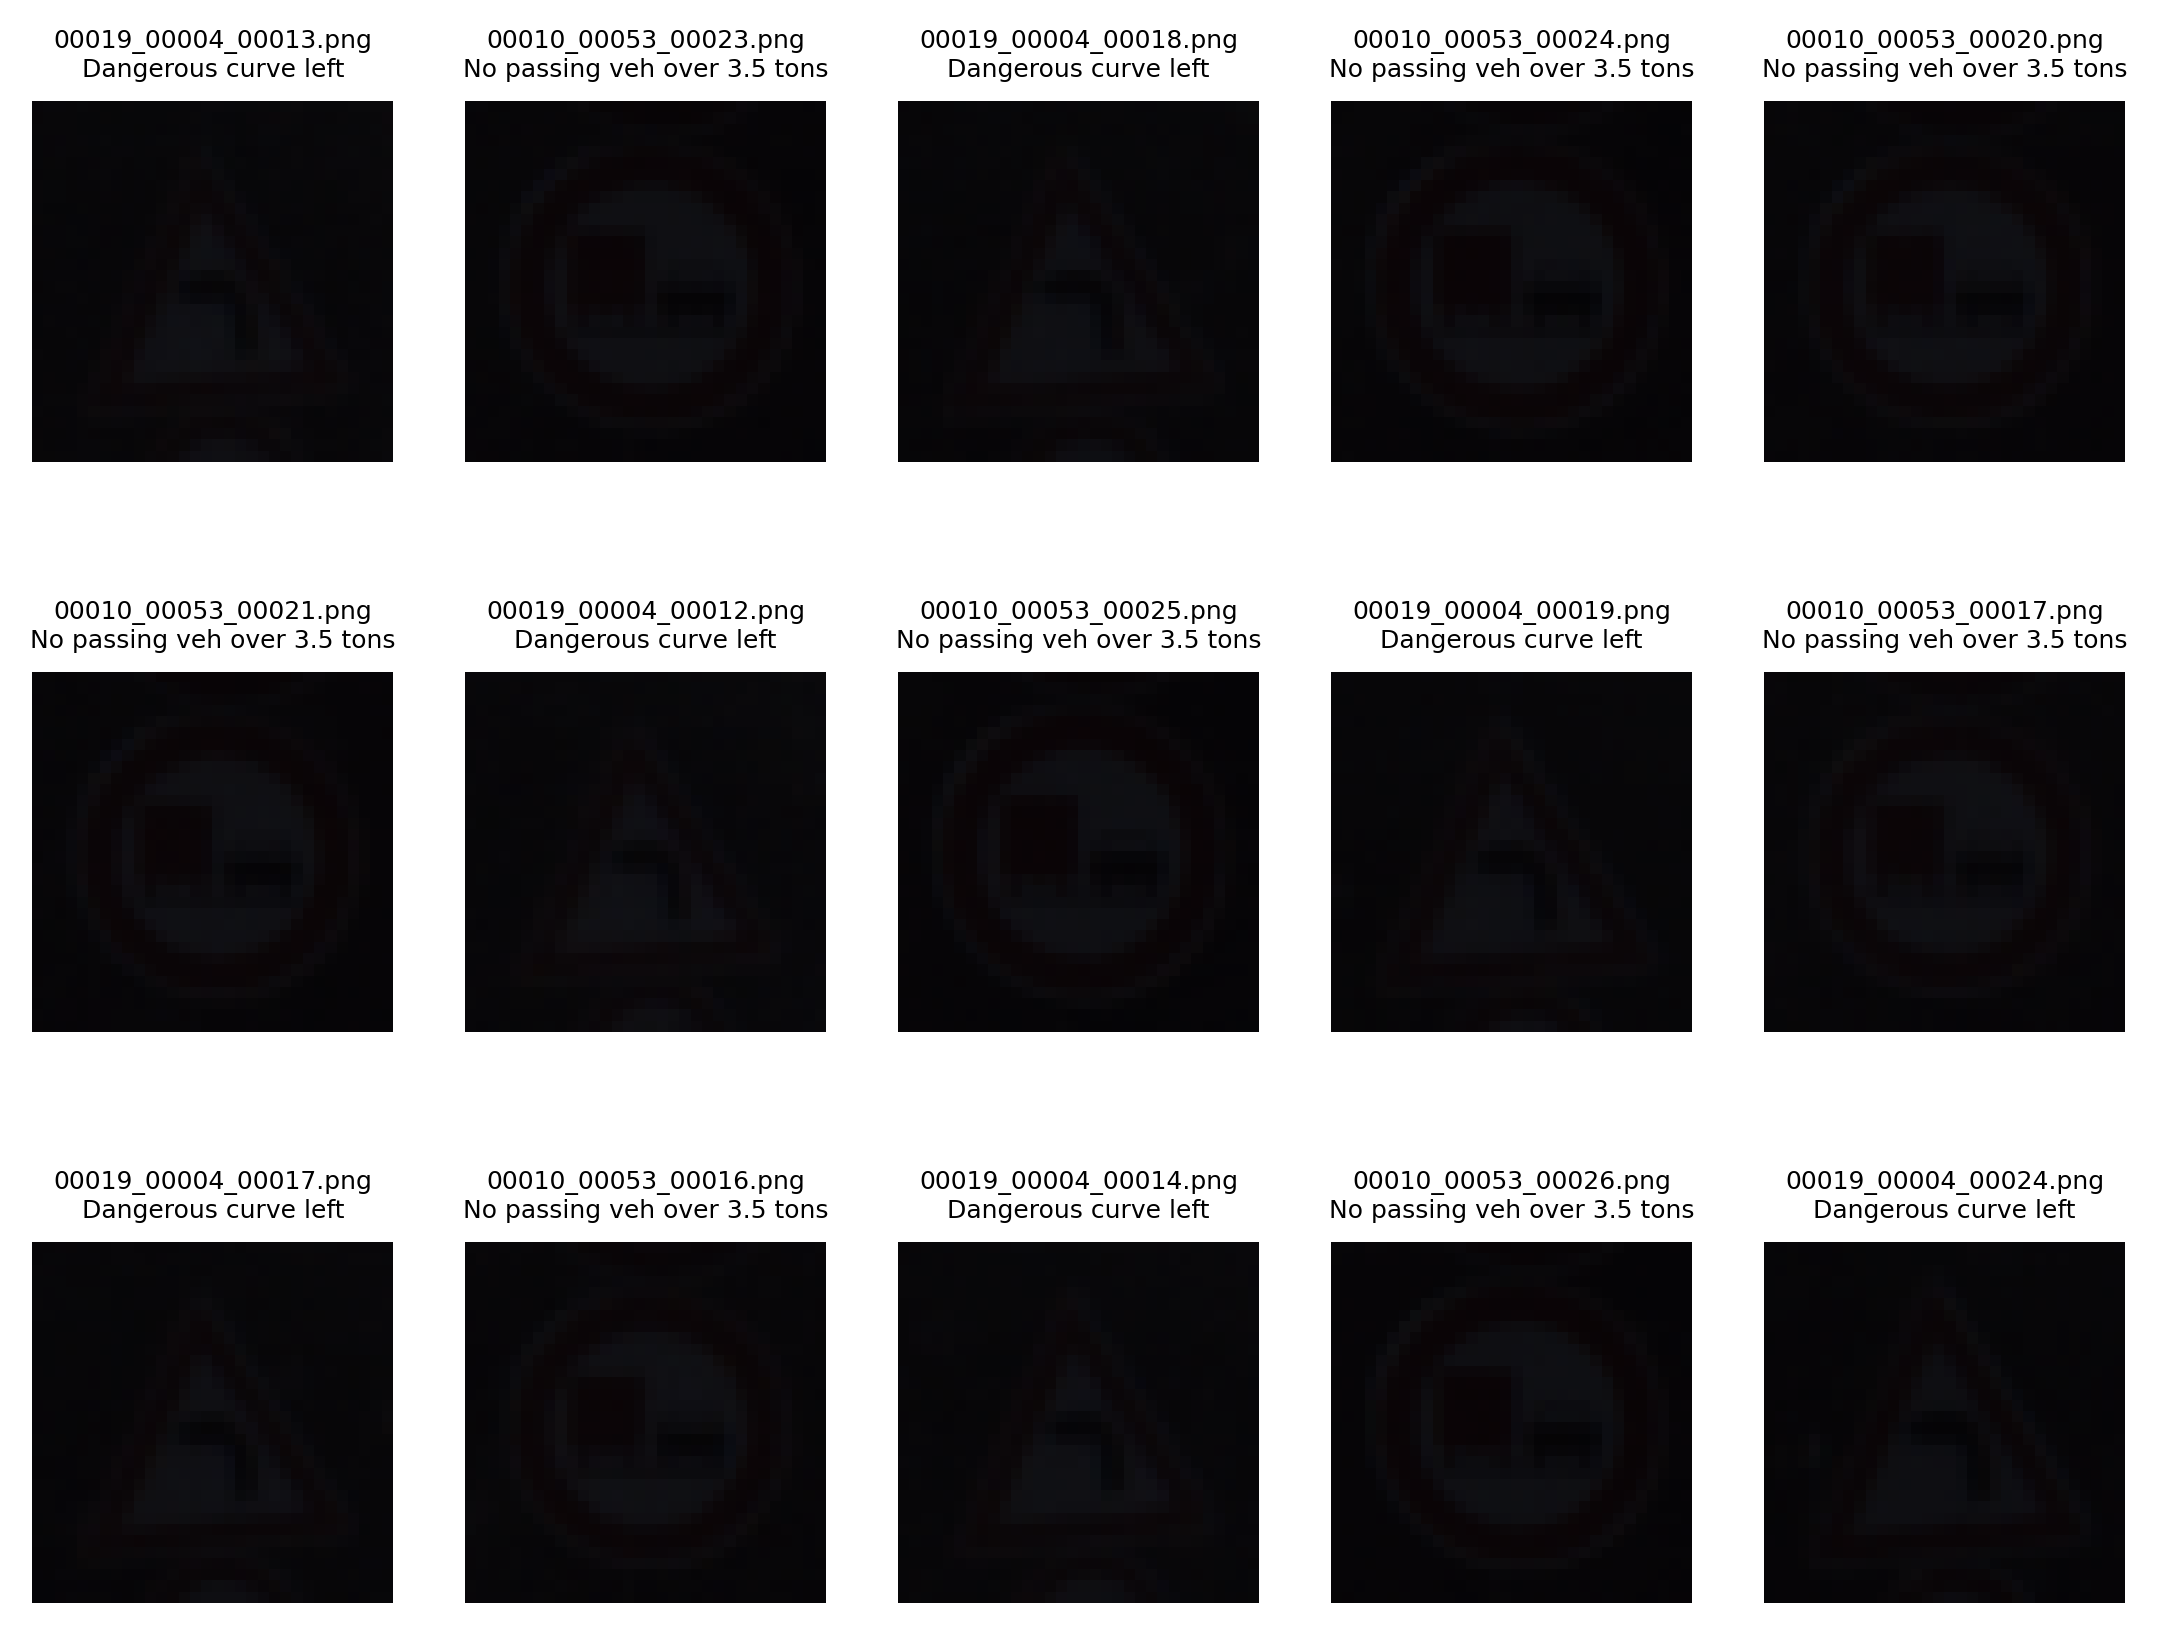

<Figure size 900x700 with 0 Axes>

In [7]:
print('----------- resnet50 model -----------')
bottom_train_ood_features_idxs = find_top_issues(quality_scores=-train_ood_features_scores, top=15)
visualize_outliers(bottom_train_ood_features_idxs, trainset)
print('----------- traffic model -----------')
bottom_train_ood_features_idxs_traffic = find_top_issues(quality_scores=-train_ood_features_scores_traffic, top=15)
visualize_outliers(bottom_train_ood_features_idxs_traffic, trainset)

----------- resnet50 model -----------


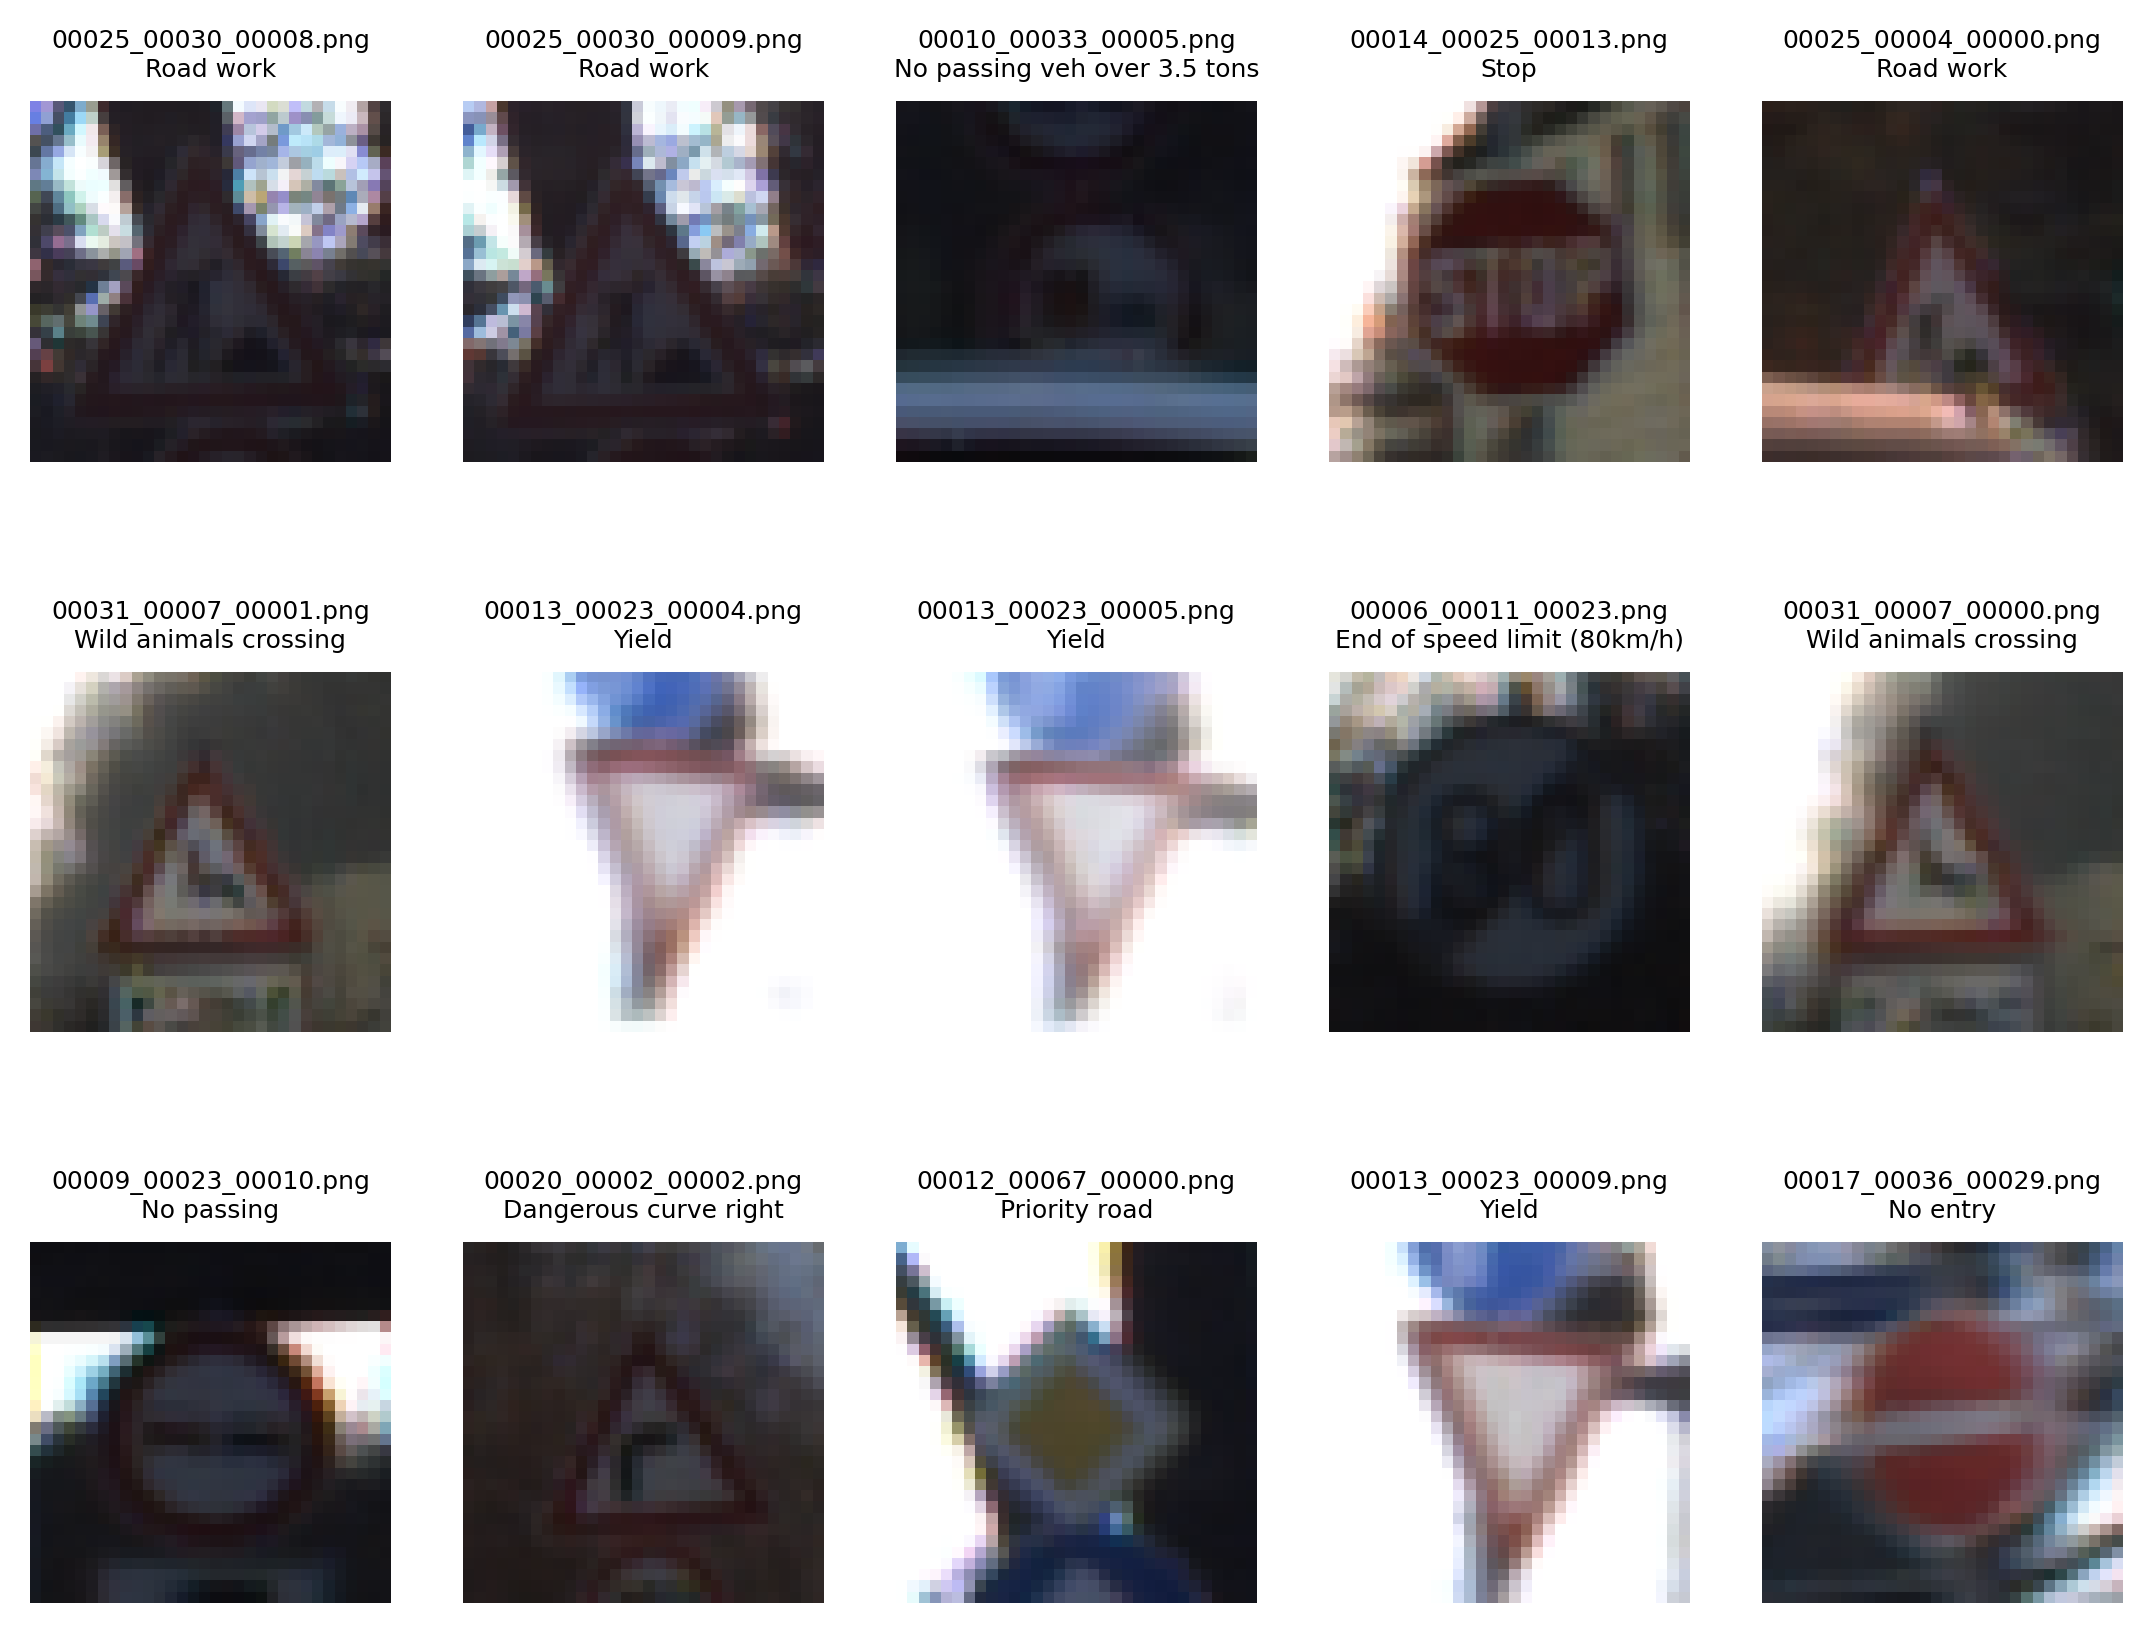

----------- traffic model -----------


<Figure size 900x700 with 0 Axes>

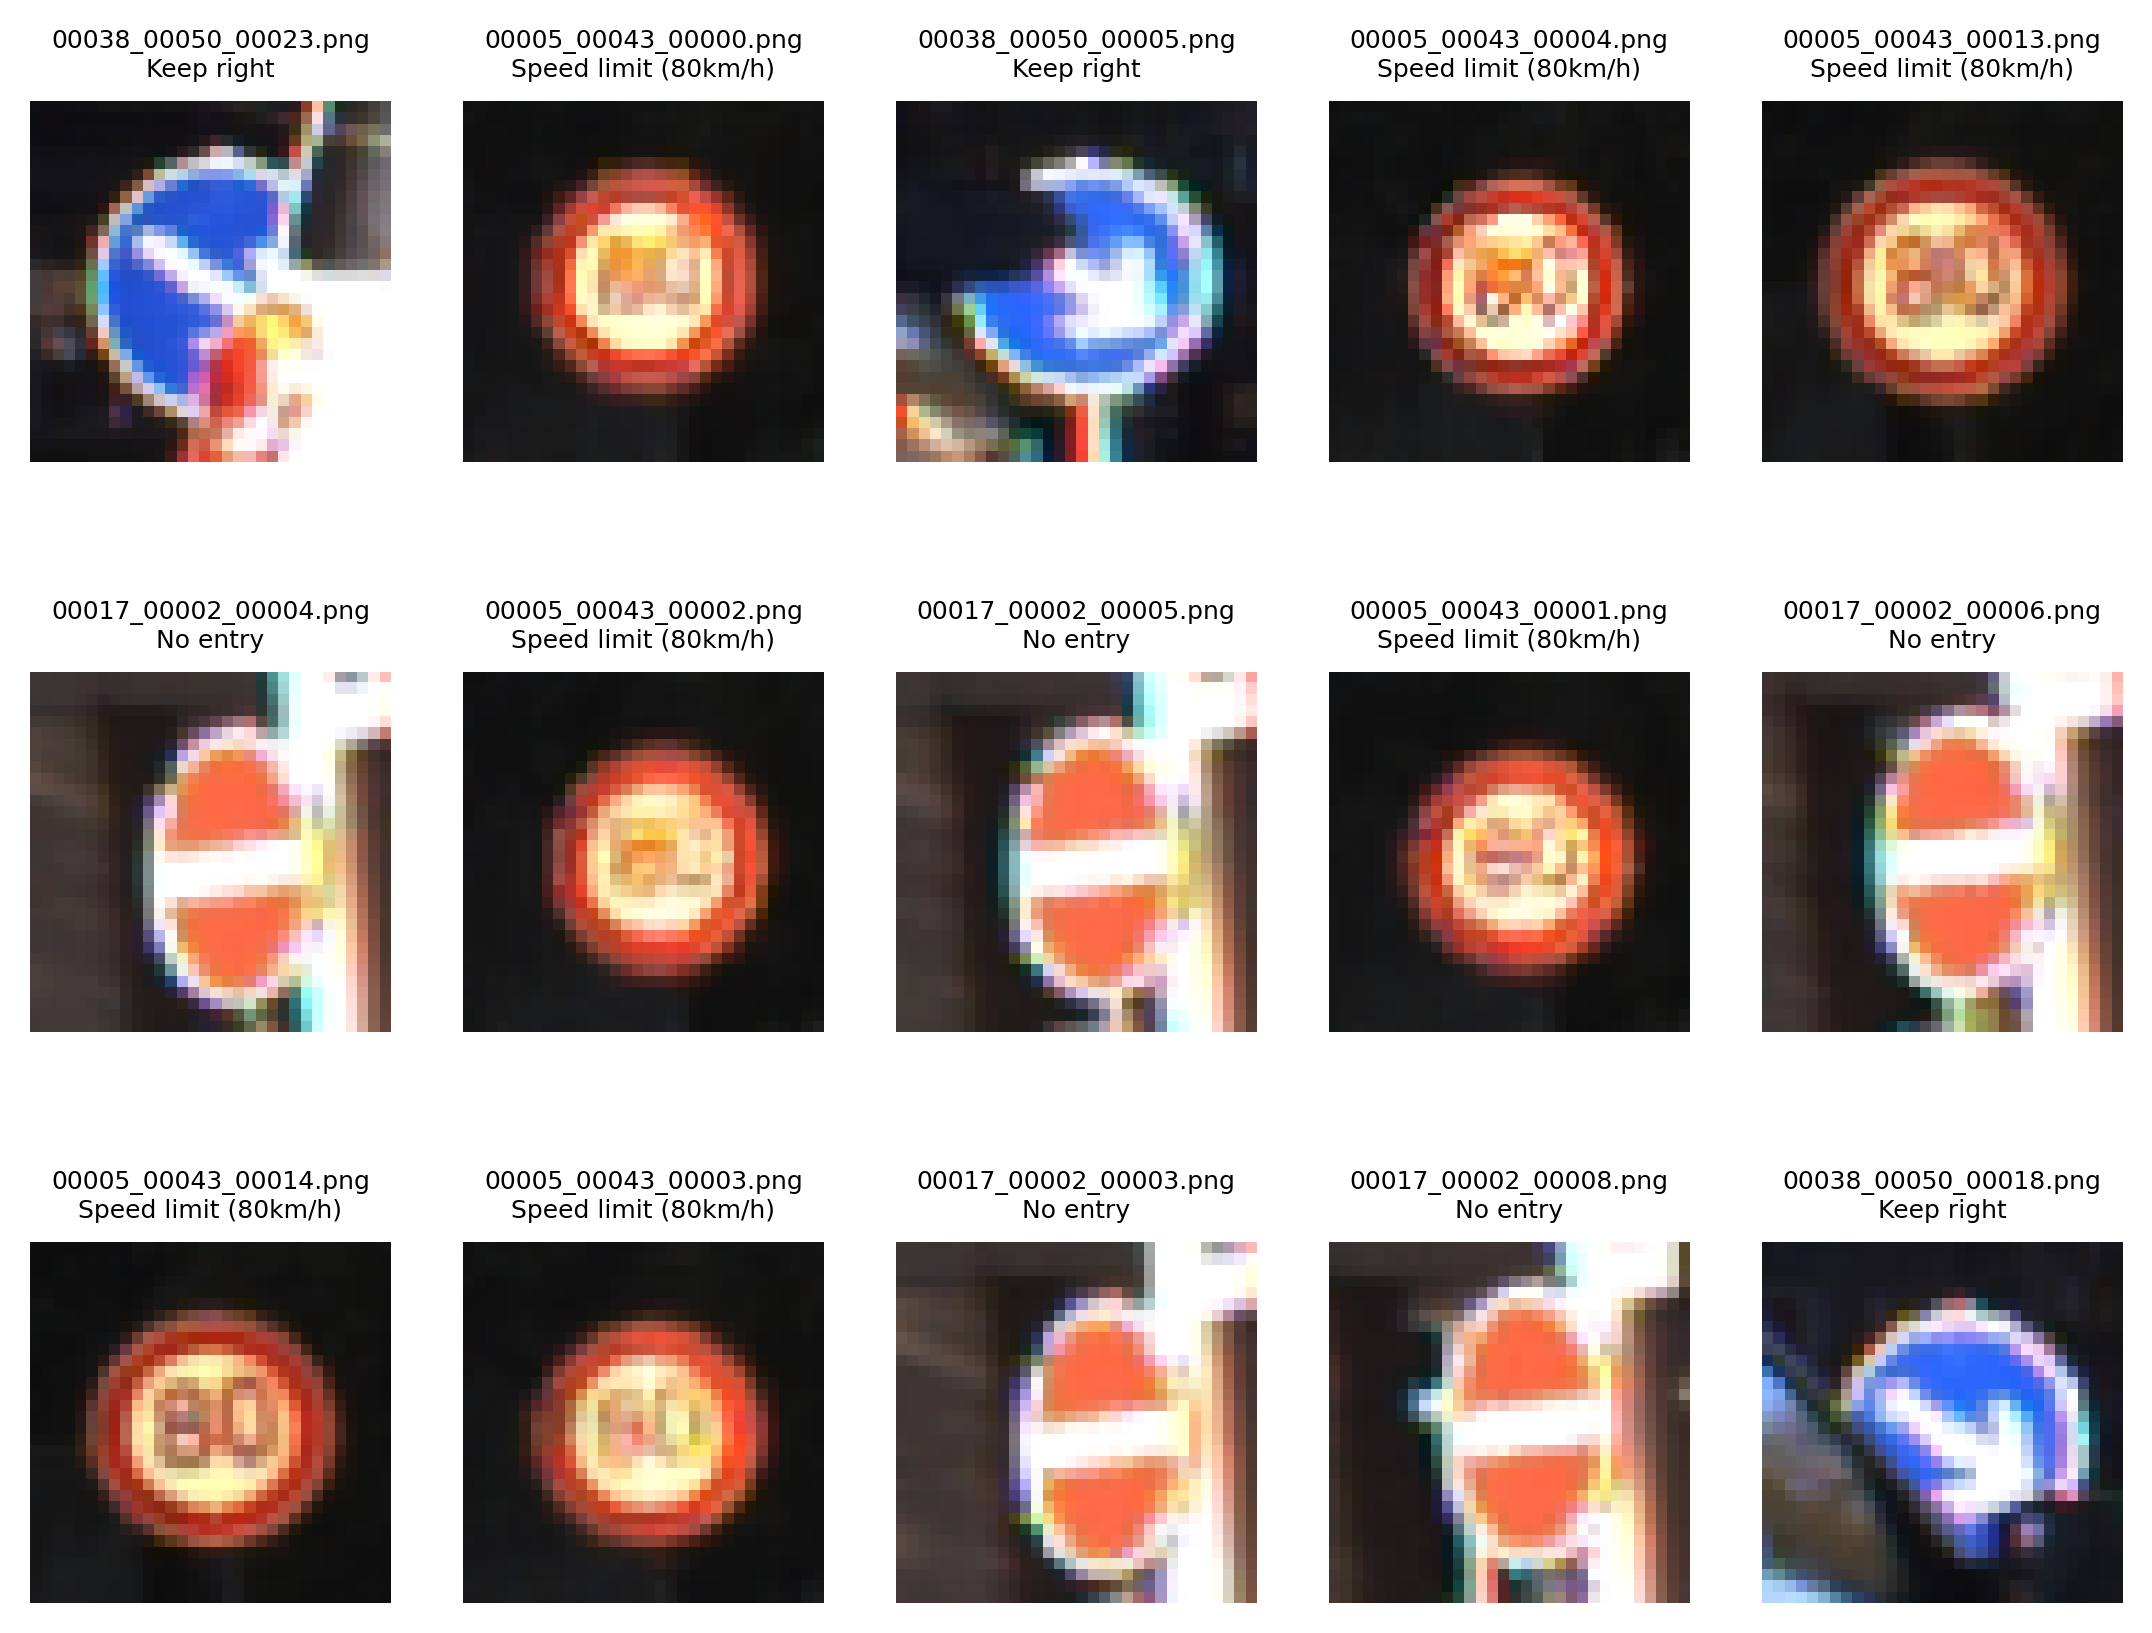

<Figure size 900x700 with 0 Axes>

In [8]:
print('----------- resnet50 model -----------')
test_ood_features_scores = ood.score(features=test_feature_embeddings)

top_ood_features_idxs = find_top_issues(test_ood_features_scores, top=15)
visualize_outliers(top_ood_features_idxs, testset)
print('----------- traffic model -----------')
test_ood_features_scores_traffic = ood_traffic.score(features=test_feature_embeddings_traffic)

top_ood_features_idxs_traffic = find_top_issues(test_ood_features_scores_traffic, top=15)
visualize_outliers(top_ood_features_idxs_traffic, testset)

----------- resnet50 model -----------


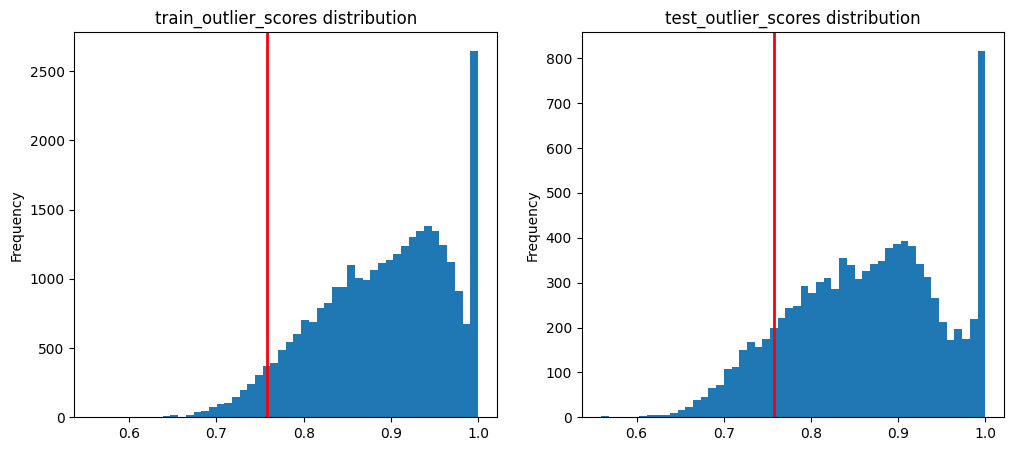

----------- traffic model -----------


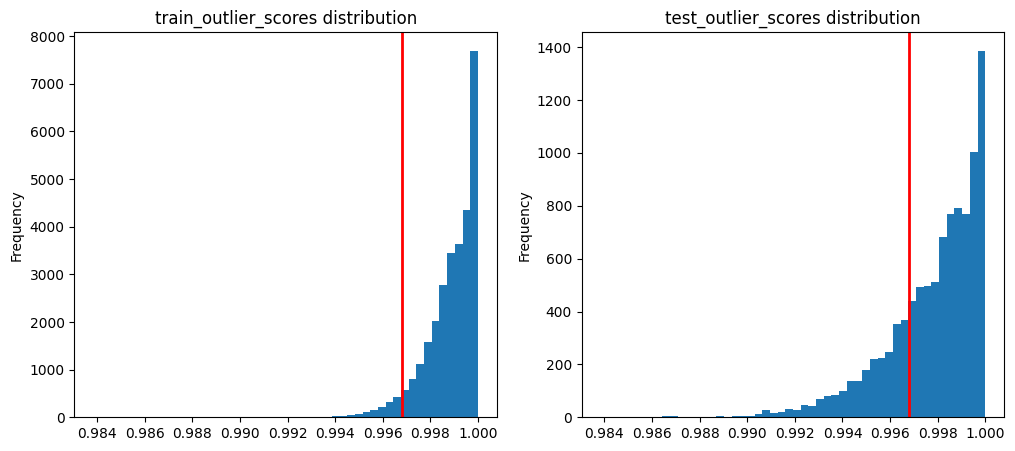

In [9]:
print('----------- resnet50 model -----------')
fifth_percentile = np.percentile(train_ood_features_scores, 5)  # 5th percentile of the train_data distribution

# Plot outlier_score distributions and the 5th percentile cutoff
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
plt_range = [min(train_ood_features_scores.min(),test_ood_features_scores.min()), \
             max(train_ood_features_scores.max(),test_ood_features_scores.max())]
axes[0].hist(train_ood_features_scores, range=plt_range, bins=50)
axes[0].set(title='train_outlier_scores distribution', ylabel='Frequency')
axes[0].axvline(x=fifth_percentile, color='red', linewidth=2)
axes[1].hist(test_ood_features_scores, range=plt_range, bins=50)
axes[1].set(title='test_outlier_scores distribution', ylabel='Frequency')
axes[1].axvline(x=fifth_percentile, color='red', linewidth=2)

plt.show()

print('----------- traffic model -----------')
fifth_percentile_traffic = np.percentile(train_ood_features_scores_traffic, 5)  # 5th percentile of the train_data distribution

# Plot outlier_score distributions and the 5th percentile cutoff
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
plt_range = [min(train_ood_features_scores_traffic.min(),test_ood_features_scores_traffic.min()), \
             max(train_ood_features_scores_traffic.max(),test_ood_features_scores_traffic.max())]
axes[0].hist(train_ood_features_scores_traffic, range=plt_range, bins=50)
axes[0].set(title='train_outlier_scores distribution', ylabel='Frequency')
axes[0].axvline(x=fifth_percentile_traffic, color='red', linewidth=2)
axes[1].hist(test_ood_features_scores_traffic, range=plt_range, bins=50)
axes[1].set(title='test_outlier_scores distribution', ylabel='Frequency')
axes[1].axvline(x=fifth_percentile_traffic, color='red', linewidth=2)

plt.show()

----------- resnet50 model -----------
ood_features_scores=[0.559023   0.5626585  0.58288515 ... 0.999831   0.99985856 0.99986005]


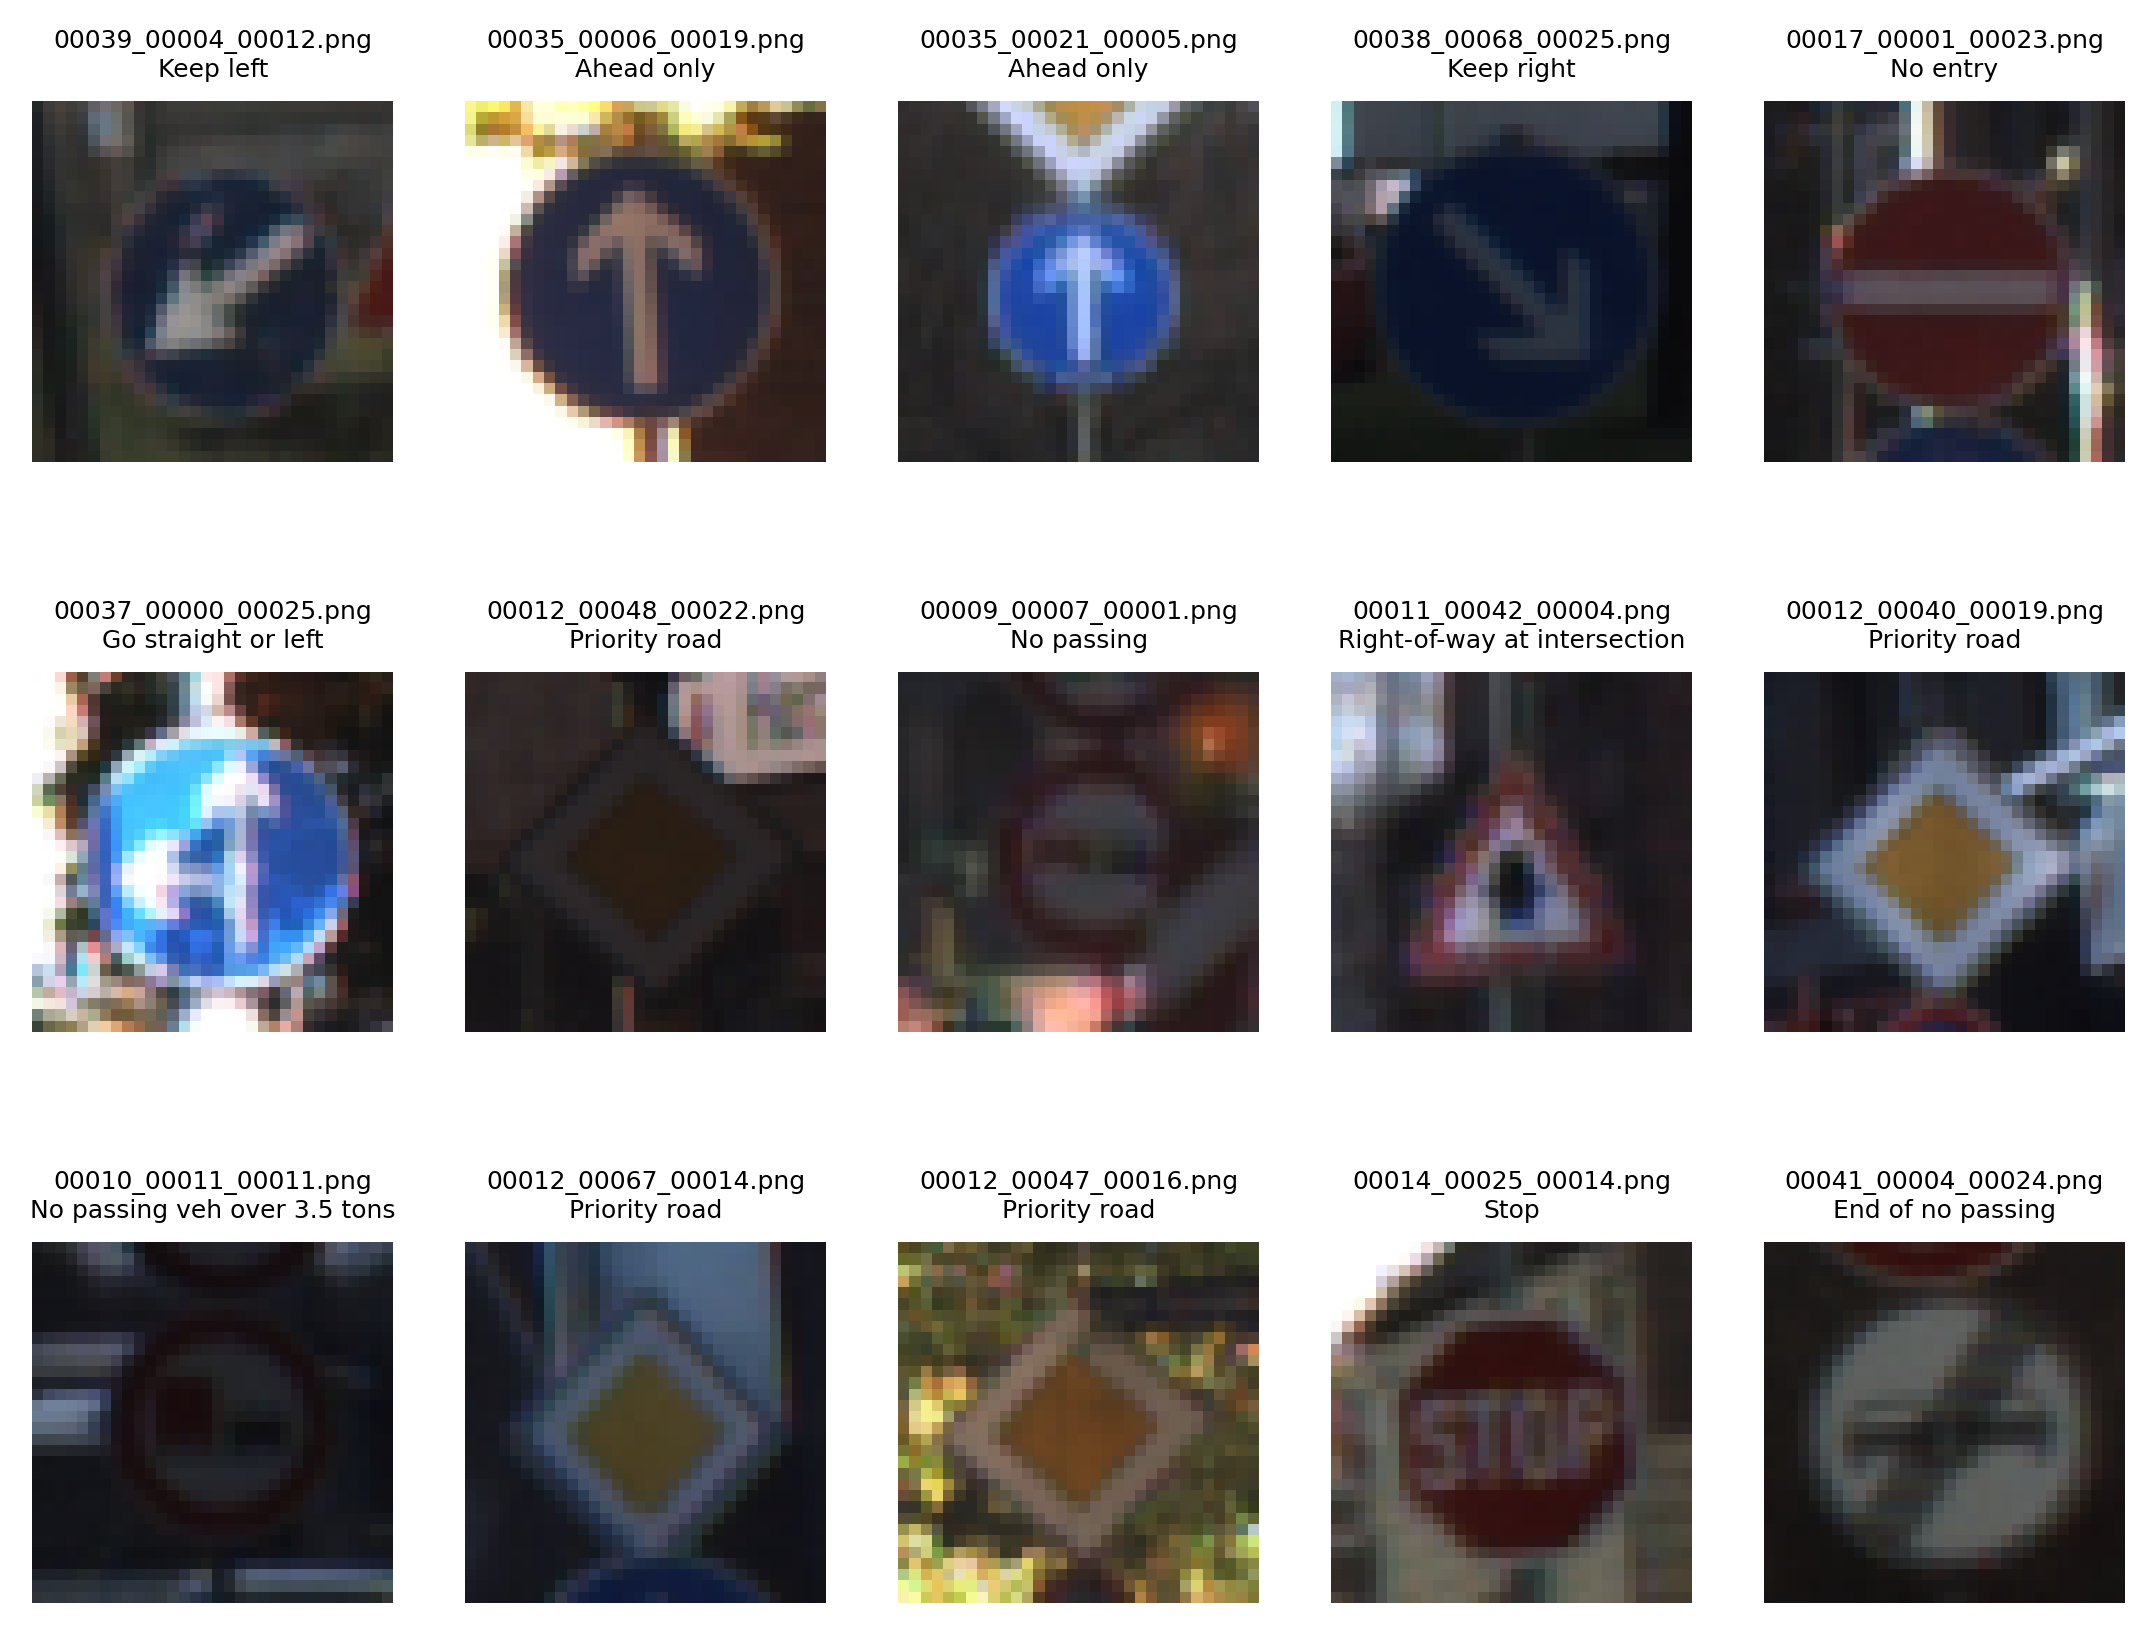

----------- traffic model -----------
ood_features_scores_traffic=[0.98385495 0.98610586 0.9861289  ... 0.9999718  0.99997187 0.9999721 ]


<Figure size 900x700 with 0 Axes>

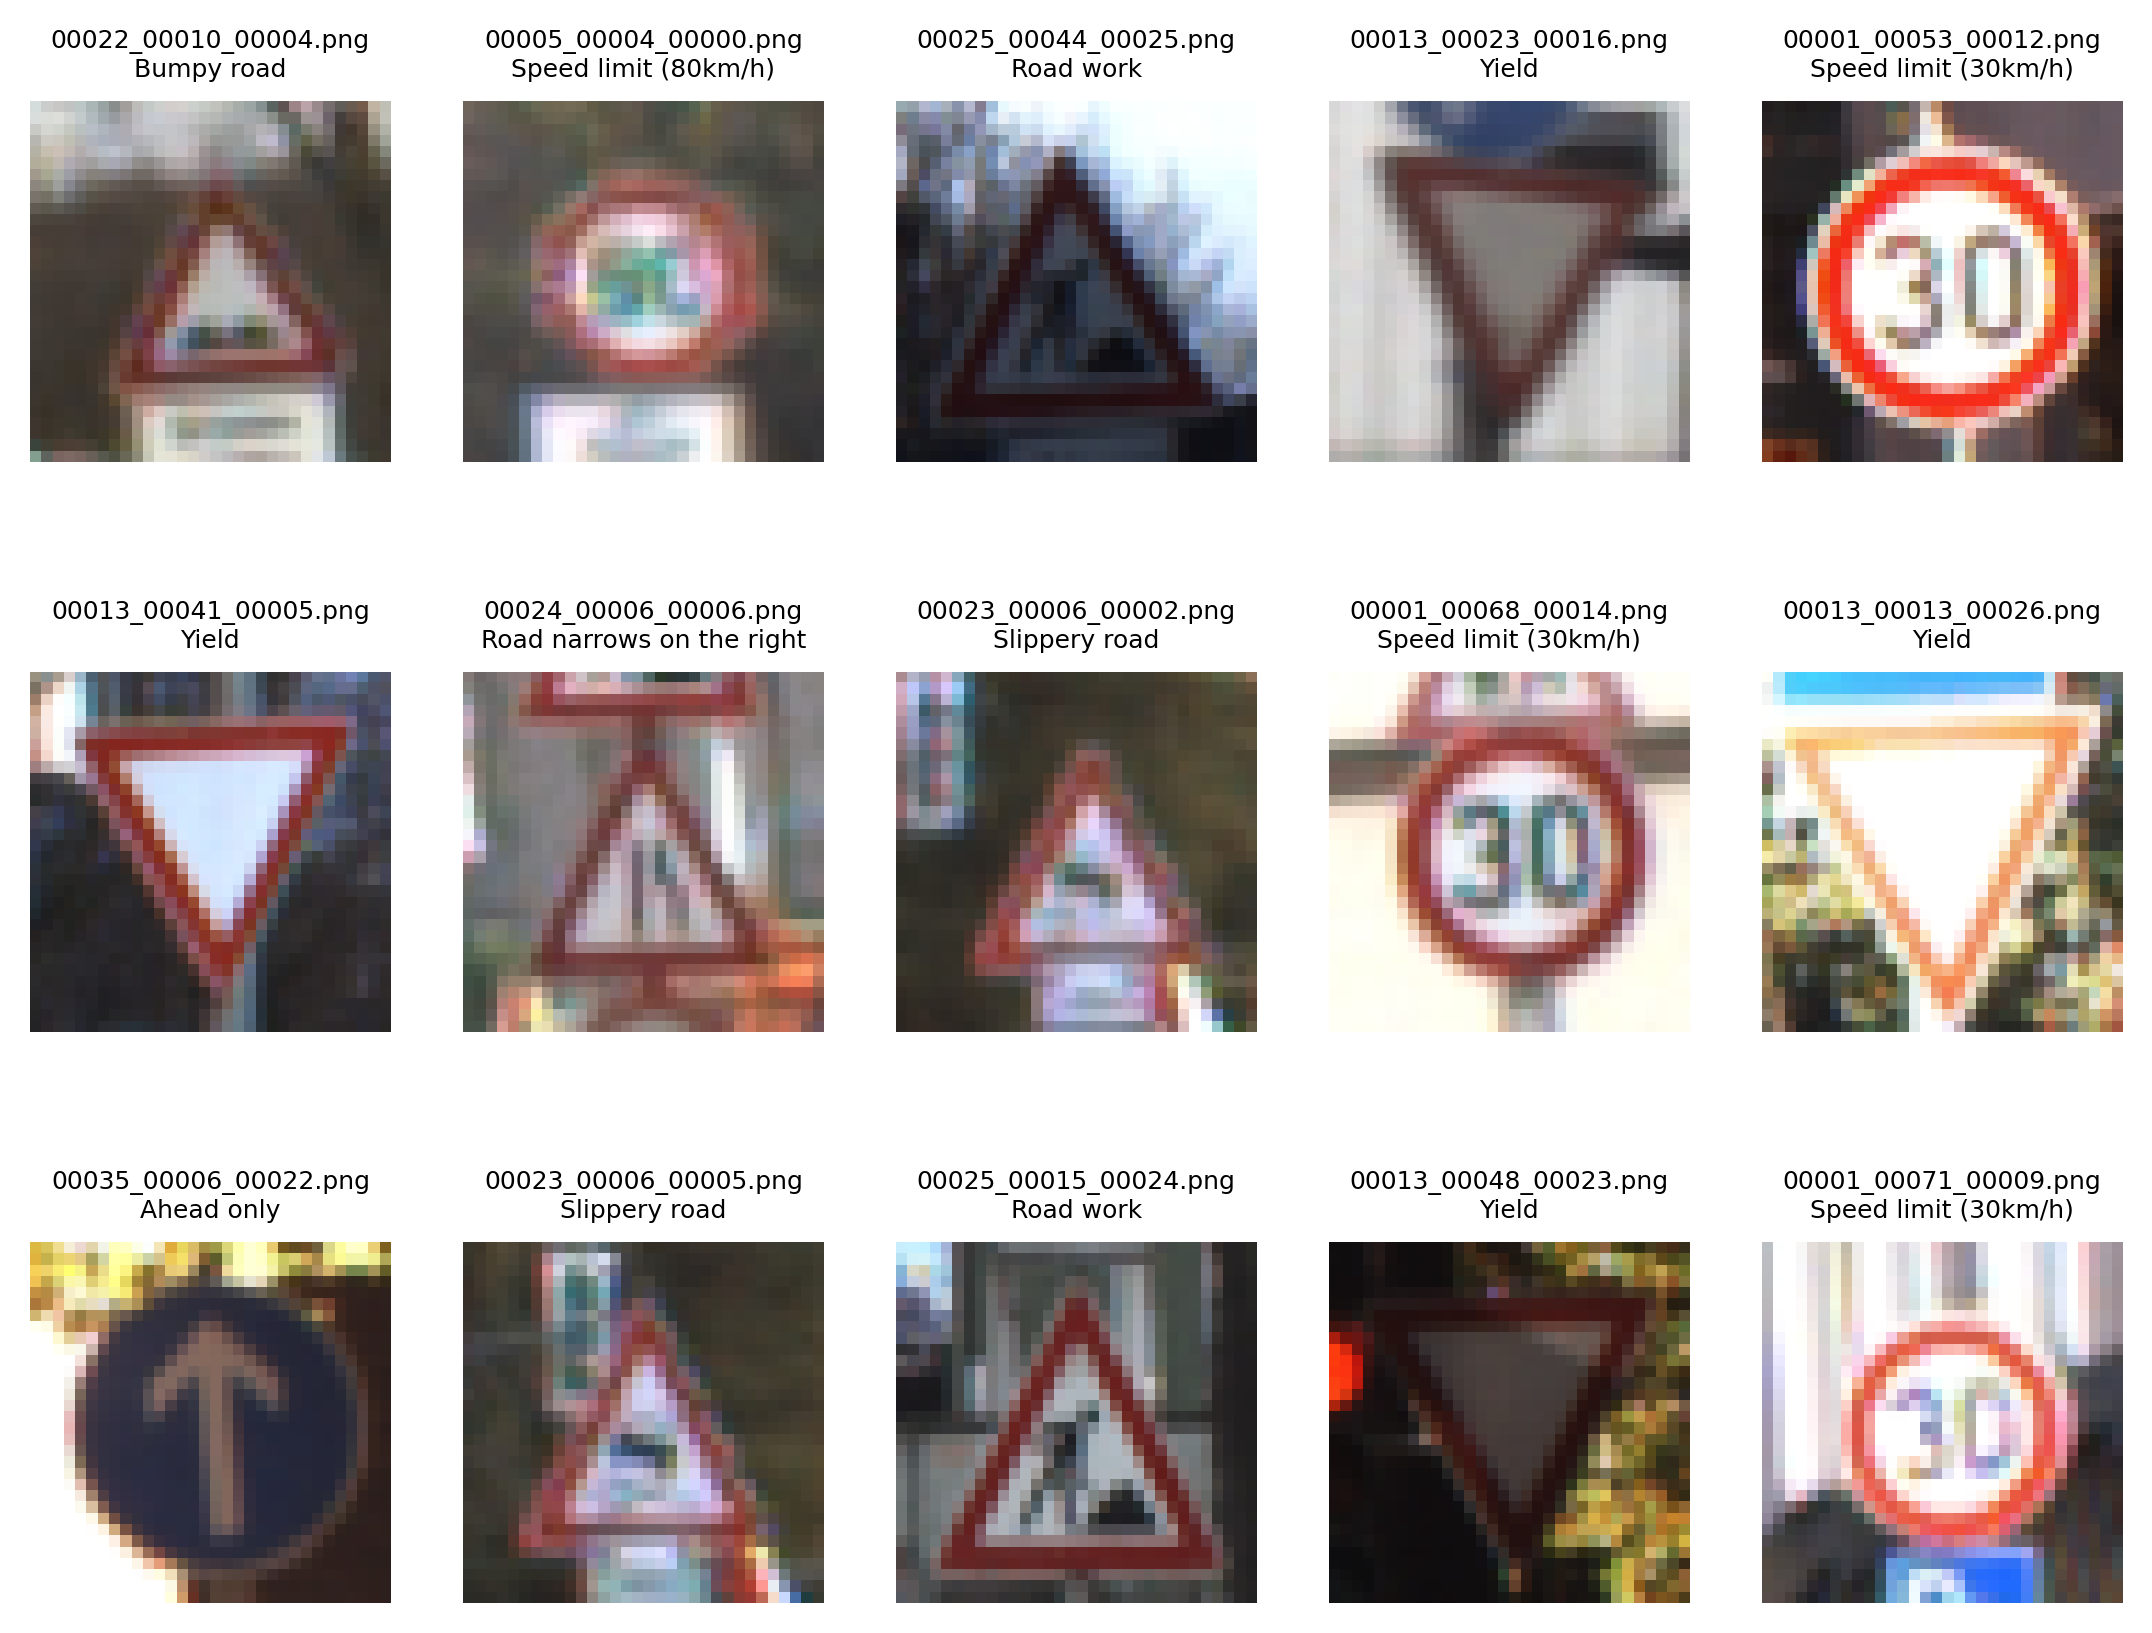

<Figure size 900x700 with 0 Axes>

In [10]:
print('----------- resnet50 model -----------')
sorted_idxs = test_ood_features_scores.argsort()
ood_features_scores = test_ood_features_scores[sorted_idxs]
ood_features_indices = sorted_idxs[ood_features_scores < fifth_percentile]  # Images in test data flagged as outliers
print(f'ood_features_scores={ood_features_scores}')
visualize_outliers(ood_features_indices[::-1], testset)

print('----------- traffic model -----------')
sorted_idxs_traffic = test_ood_features_scores_traffic.argsort()
ood_features_scores_traffic = test_ood_features_scores_traffic[sorted_idxs_traffic]
ood_features_indices_traffic = sorted_idxs_traffic[ood_features_scores_traffic < fifth_percentile_traffic]  # Images in test data flagged as outliers
print(f'ood_features_scores_traffic={ood_features_scores_traffic}')

visualize_outliers(ood_features_indices_traffic[::-1], testset)

# t-SNE

----------------- feature_embeddings_traffic -----------------


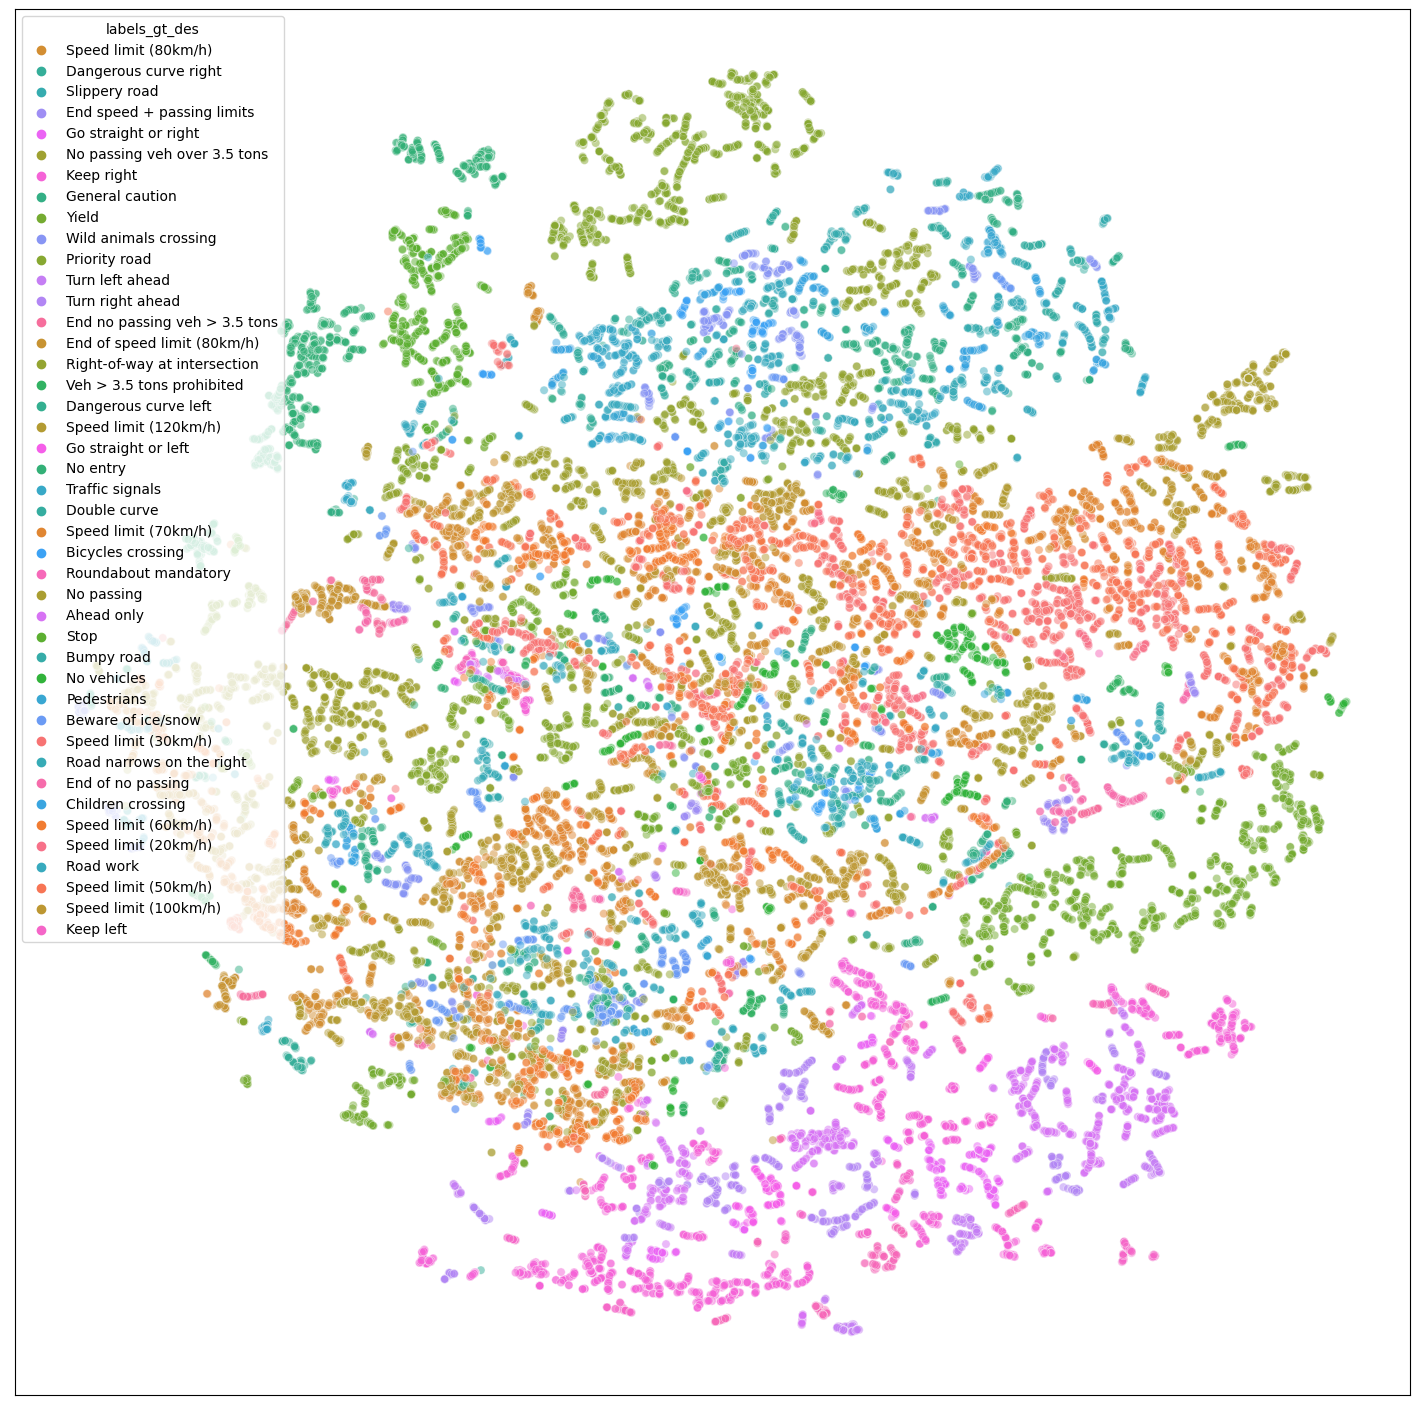

----------------- feature_embeddings -----------------


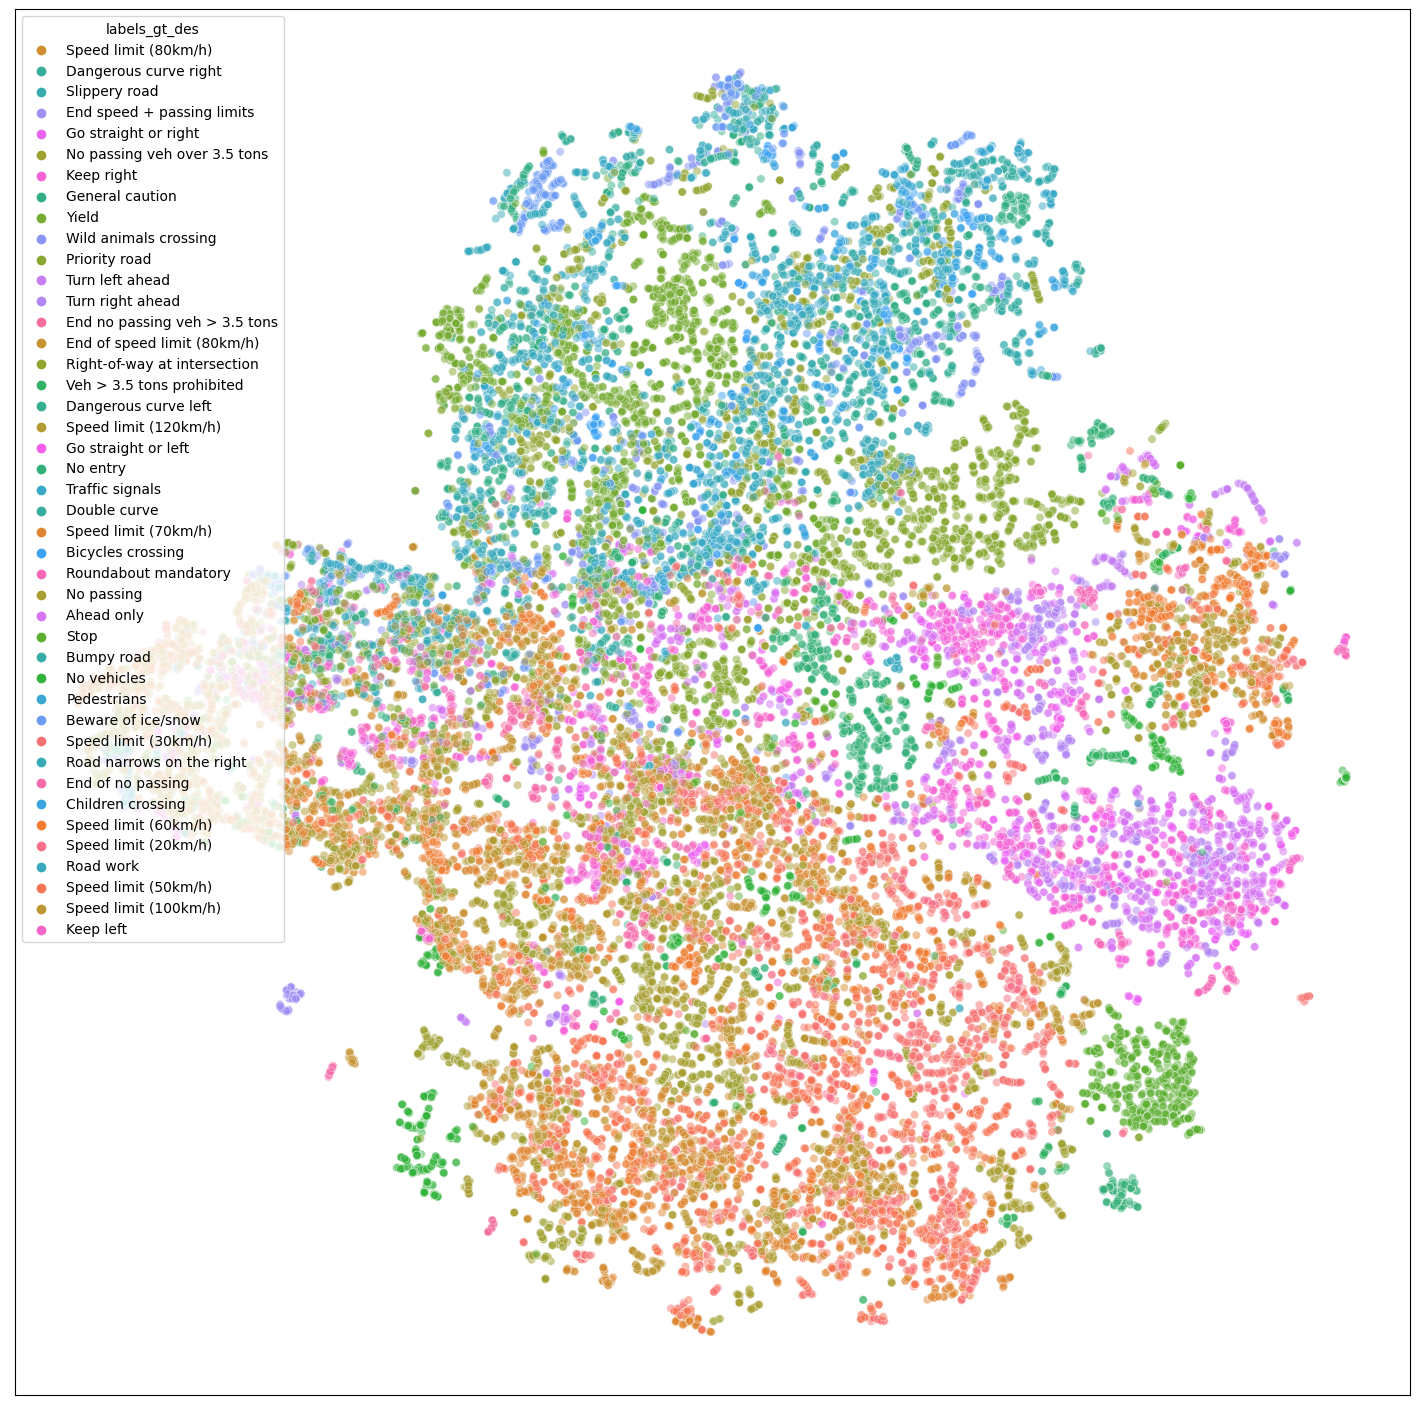

In [11]:
feature_embeddings_resnet = np.concatenate((train_feature_embeddings, test_feature_embeddings), axis=0)
feature_embeddings_traffic = np.concatenate((train_feature_embeddings_traffic, test_feature_embeddings_traffic), axis=0)

def tsne_embedding(perplexity, classes_name, imgnames, labels_gt, labels_gt_des, embeddings):
    
    color_list = sns.color_palette("husl", len(classes_name)).as_hex()
    id_to_color = {k: v for k, v in zip(range(len(classes_name)), color_list)}
    classname_to_color = {k: v for k, v in zip(classes_name.values(), color_list)}
#     marker_mapper = dict({"Train": "o", "Test": "x"})
#     print(f'color_mapper={color_mapper}')
#     return
    
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=0)
    tsne_output = tsne.fit_transform(embeddings)
    df = pd.DataFrame(tsne_output, columns=['x', 'y'])
    
    df['labels_gt'] = labels_gt
    df['labels_gt_des'] = labels_gt_des
    df['imgname'] = imgnames
    df.sort_values(by=['labels_gt'], ascending=False)
    
    plt.rcParams['figure.figsize'] = 18, 18
    s1 = sns.scatterplot(
        x='x', y='y',
        hue='labels_gt_des',
        data=df,
        legend="full",
        palette = classname_to_color,
        alpha=0.5
    )
    
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    
    plt.show()


print('----------------- feature_embeddings_traffic -----------------')
tsne_embedding(len(classes_name), classes_name, total_imgnames, total_labels_gt, total_labels_gt_des, feature_embeddings_traffic)
# print('----------------- train_feature_embeddings_traffic -----------------')
# tsne_embedding(train_feature_embeddings_traffic)
# print('----------------- test_feature_embeddings_traffic -----------------')
# tsne_embedding(test_feature_embeddings_traffic)

print('----------------- feature_embeddings -----------------')

tsne_embedding(len(classes_name), classes_name, total_imgnames, total_labels_gt, total_labels_gt_des, feature_embeddings_resnet)



def tsne_plot(imagenames, targets, preds, outputs, ranked_label_issues, color_num, filename, show_filename=False):
    print('generating t-SNE plot...')

    tsne_perplexity = 7
    tsne = TSNE(n_components=2, perplexity=tsne_perplexity, random_state=0)
    tsne_output = tsne.fit_transform(outputs)

    df = pd.DataFrame(tsne_output, columns=['x', 'y'])
    targets = [cls_mapper[i] for i in targets]
    preds = [cls_mapper[i] for i in preds]
    
#     print(f'targets={targets}')
#     print(f'preds={preds}')
#     ranked_label_issues = compareList(targets, preds, find_true=False)
#     print(f'ranked_label_issues={ranked_label_issues}')
    
    targets = ['wrong' if idx in ranked_label_issues else i for idx, i in enumerate(targets)]
    marker_mapper = dict({"healthy": "o", "PD": "o", "wrong": "x"})
    color_dict = dict({'healthy':'blue',
                  'PD':'green',
                  'wrong': 'red'})
    markers = [marker_mapper[i] for i in targets]
    df['targets'] = targets
    df['imagename'] = imagenames
    df.sort_values(by=['targets'], ascending=False)
#     print(df)
    print(df.to_string())
    
    plt.rcParams['figure.figsize'] = 18, 18
    s1 = sns.scatterplot(
        x='x', y='y',
        hue='targets',
        data=df,
        legend="full",
        palette = color_dict,
        alpha=0.5
    )
    
    if show_filename is True:
        for line in range(0, df.shape[0]):
            s1.text(df['x'][line]+0.01, df['y'][line], 
                     df['imagename'][line], horizontalalignment='left', 
                     size=6, color='black', weight='light')    

    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    
    plt.savefig(os.path.join('./report/', f'{filename}_plex{tsne_perplexity}.png'), bbox_inches='tight', dpi=500)
    plt.show()


# labels_wrong = np.take(labels_all, ranked_label_issues, axis=0)
# outputs_wrong = np.take(outputs_all, ranked_label_issues, axis=0)


# imagenames = [i[0].split(os.path.sep)[-1] for i in imagenames_all]

# tsne_plot(imagenames, labels_all, preds_all, outputs_all, [], color_num=2, filename='tsne_gt', show_filename=False)
# tsne_plot(imagenames, labels_all, preds_all, outputs_all, ranked_label_issues, color_num=3, filename='tsne_wrong', show_filename=False)

# tsne_plot(imagenames, labels_all, preds_all, outputs_all, [], color_num=2, filename='tsne_gt_name', show_filename=True)
# tsne_plot(imagenames, labels_all, preds_all, outputs_all, ranked_label_issues, color_num=3, filename='tsne_wrong_name', show_filename=True)

# imagesnames_ho_noaug_split = [i[0].split(os.path.sep)[-1] for i in imagesnames_ho_noaug]

# tsne_plot(imagesnames_ho_noaug_split, labels_ho_noaug, preds_ho_noaug, outputs_ho_noaug, [], color_num=2, filename='trainall_no_noaug_gt', show_filename=False)
# tsne_plot(imagesnames_ho_noaug_split, labels_ho_noaug, preds_ho_noaug, outputs_ho_noaug, ho_noaug_predwrong_idxs, color_num=3, filename='trainall_no_noaug_predwrong', show_filename=False)
# tsne_plot(imagesnames_ho_noaug_split, labels_ho_noaug, preds_ho_noaug, outputs_ho_noaug, ho_noaug_predwrong_idxs, color_num=3, filename='trainall_no_noaug_predwrong_name', show_filename=True)
# tsne_plot(imagenames, labels_all, preds_all, outputs_all, ranked_label_issues, color_num=3, filename='tsne_wrong_name', show_filename=True)
